In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

In [2]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')

agg_df_cluster1 = pd.read_csv('pandas/agg_df_cluster1.csv')
fish_df_cluster1 = pd.read_csv('pandas/fish_df_cluster1.csv')
#agg_df_large = pd.read_csv('pandas/agg_df_large_cluster.csv')
#fish_df_large = pd.read_csv('pandas/fish_df_large_cluster.csv')
#agg_df_top2 = pd.read_csv('pandas/agg_df_top2.csv')
#fish_df_top2 = pd.read_csv('pandas/fish_df_top2.csv')

#agg_df_cluster2 = pd.read_csv('pandas/agg_df_cluster2.csv')
#fish_df_cluster2 = pd.read_csv('pandas/fish_df_cluster2.csv')

In [3]:
# designate which clustering to analyze
df_explore = agg_df_cluster1 # agg_df or agg_df_large or agg_df_top2
fish_explore = fish_df_cluster1 # fish_df or fish_df_large or fish_df_top2


Cluster sizes:
cluster
1     956
2     442
3     359
4     161
5      89
6      37
7      36
8      34
9      26
10     23
11     21
12     13
13     13
14     12
15     11
16     11
19      9
18      9
17      9
20      8
21      7
22      6
23      6
24      6
25      6
26      6
27      6
28      6
29      5
30      5
dtype: int64


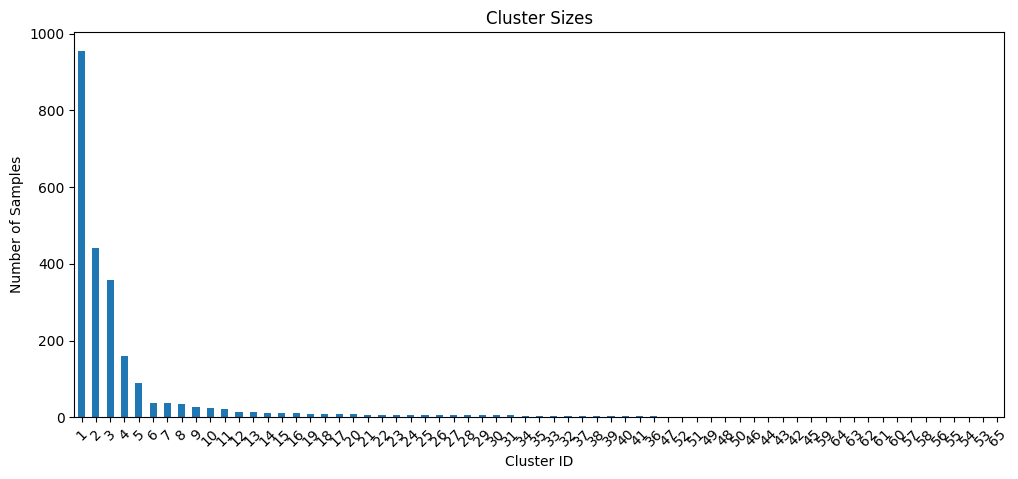

In [4]:
# Summary of clusters
cluster_summary = df_explore.groupby('cluster').size().sort_values(ascending=False)
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title('Cluster Sizes')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

# Cluster Species Composition

We next inspected how each cluster varied in it’s species composition.

We will produce three vertical heatmaps for the Jaccard clustering method. Each heatmap shows the average percent presence of each fish species (rows) within each cluster (columns).

*What the graph means:*

-   **Columns**: Each column is a cluster of assemblages (sites grouped by fish community similarity).
-   **Rows**: Each row is a fish species (only those present in >10% of any cluster).
-   **Cell values**: The number in each cell is the percent of assemblages in that cluster where the species is present (0–100%).
-   **Color**: Darker blue = higher percent presence.
-   **Interpretation**: You can see which species are common or rare in each cluster, and how species composition differs between clusters and clustering methods.

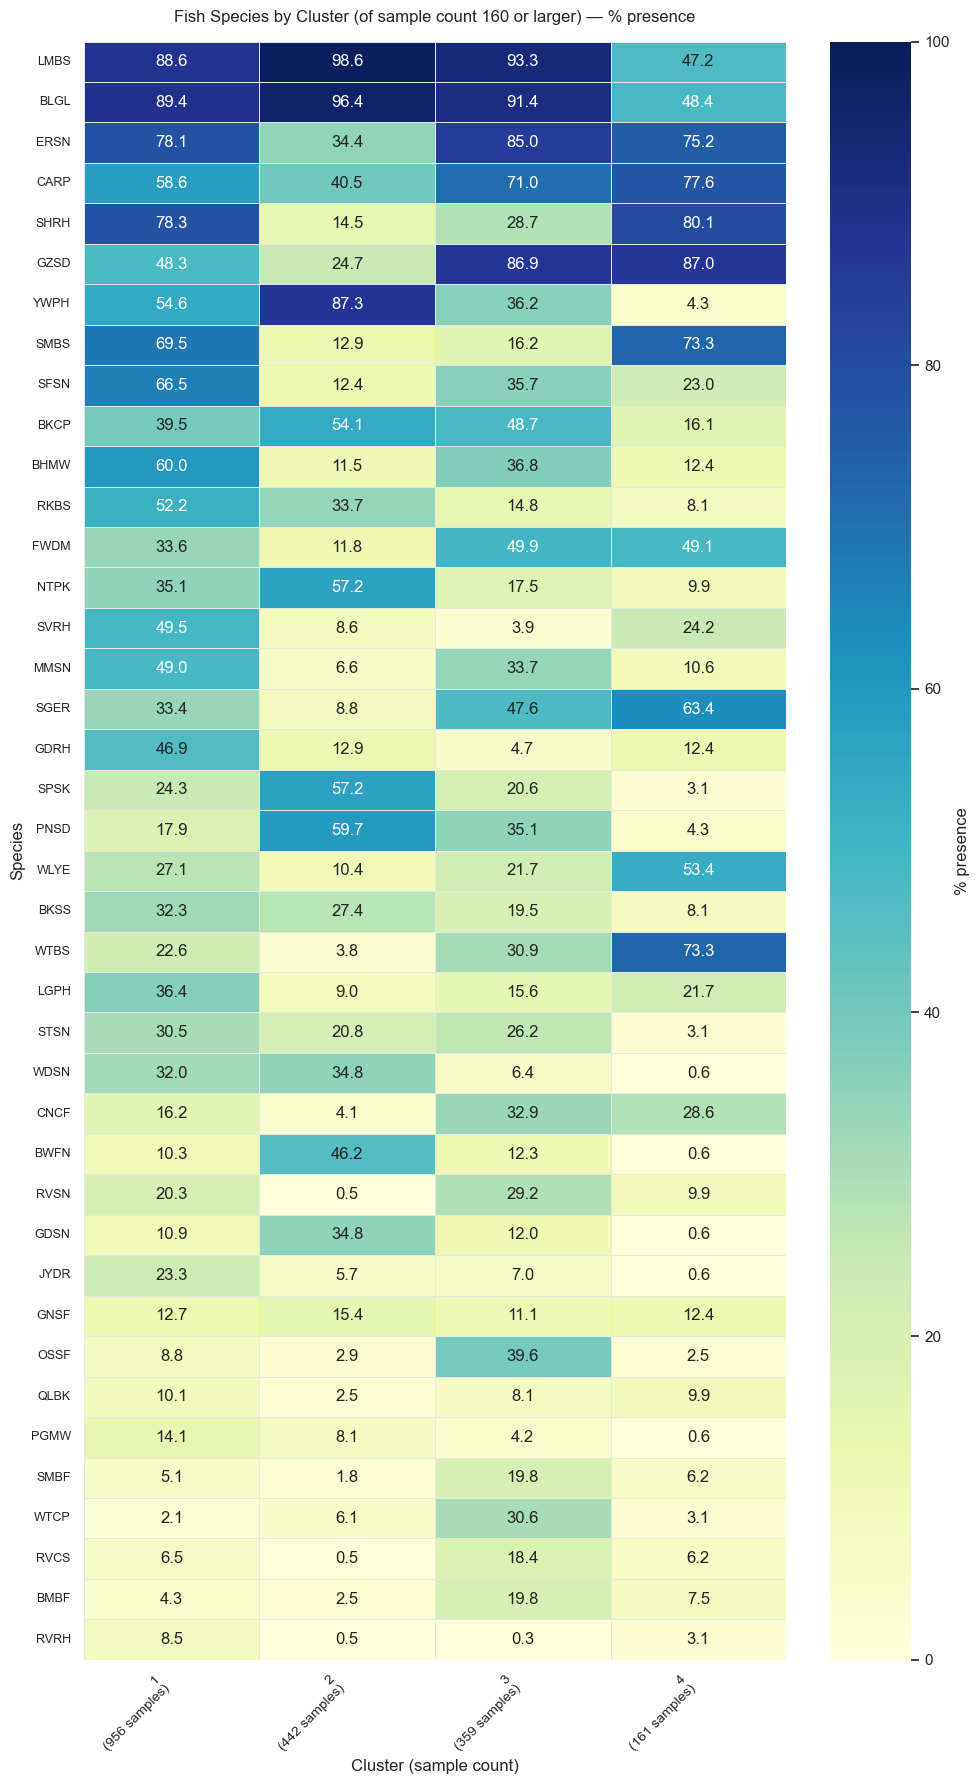

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Keep only top 20 most common species
fishcode_2_include = 41
top_species = species_order[:fishcode_2_include]

# Compute percent presence per cluster for top 20 species only
# Result: rows = cluster, cols = species
jac_comp = fish_explore.groupby('cluster')[top_species].mean() * 100

# Order clusters by overall sample count (so columns are in meaningful order)
# Filter clusters with size >= 10
# 4 cluster size > 160
# 8 cluster size > 30
cluster_filter = 160
cluster_sizes = df_explore['cluster'].value_counts()
cluster_sizes = cluster_sizes[cluster_sizes >= cluster_filter]
cluster_order = [c for c in cluster_sizes.index if c in jac_comp.index]
jac_comp = jac_comp.reindex(cluster_order)

# Transpose so rows=species, cols=cluster (more natural for reading species)
display_df = jac_comp.T

# Create readable cluster labels with site counts
col_labels = [f"{c}\n({cluster_sizes.get(c,0)} samples)" for c in display_df.columns]

# Plot
fig, ax = plt.subplots(figsize=(max(10, 0.6 * display_df.shape[1]), 0.35 * display_df.shape[0] + 4))
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # perceptually-uniform sequential

sns.heatmap(
    display_df,
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    linecolor="0.9",
    cbar_kws={"label": "% presence"}
)

ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xlabel("Cluster (sample count)")
ax.set_ylabel("Species")
ax.set_title(f"Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
#ax.set_title(f"Top {fishcode_2_include} Most Common Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
plt.tight_layout()
plt.show()
fig.savefig(
    'cluster_species_presence2.jpg',
    dpi=300,
    bbox_inches='tight',
    format='jpeg',
    pil_kwargs={'quality': 95, 'optimize': True, 'progressive': True}
)

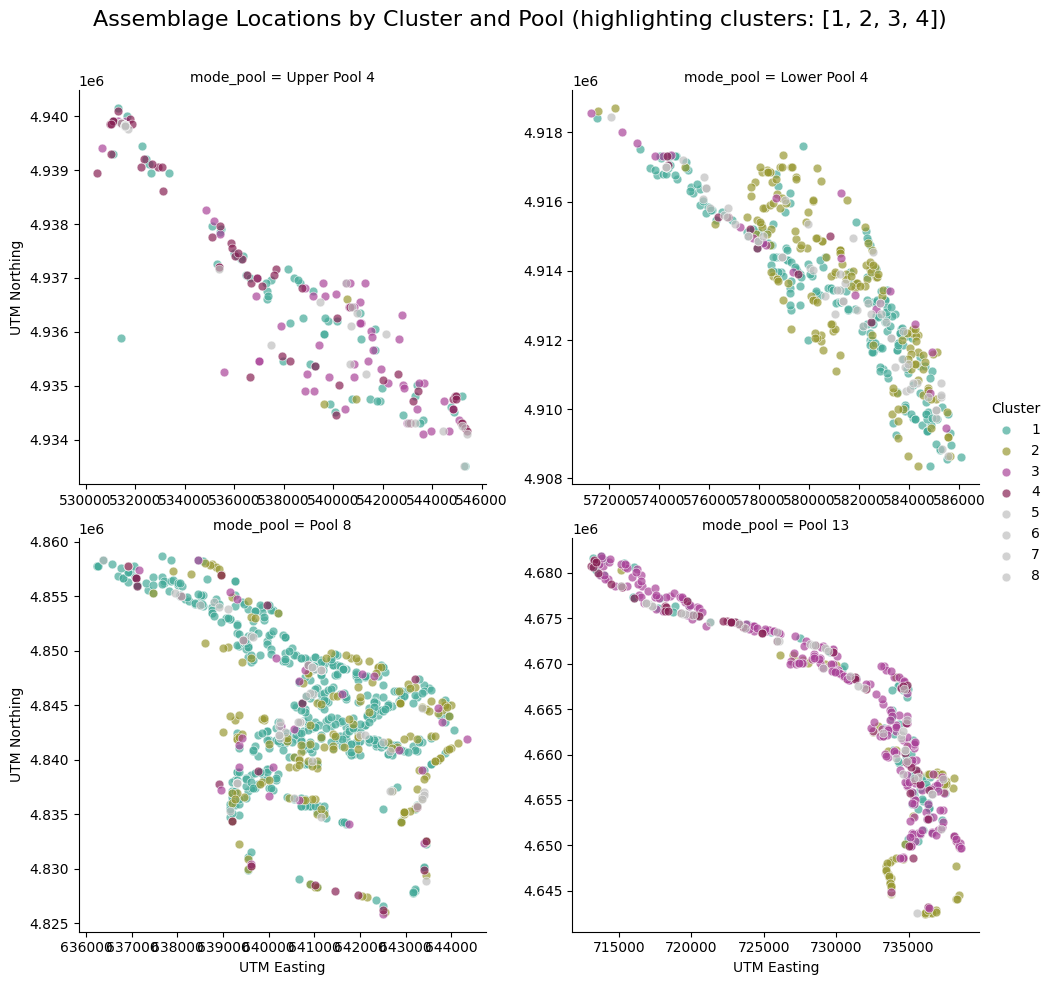

In [22]:
import tol_colors as tc

CB_PALETTE = tc.bright
# Fallback colors for clusters > 8
EXTRA_COLORS = ['#882255', '#44AA99', '#999933', '#AA4499']
GREY_COLOR = (0.75, 0.75, 0.75)  # light gray for non-highlighted clusters

# =============================================================================
# CONFIGURATION: Select clusters to highlight
# =============================================================================
highlight_clusters = [1, 2, 3, 4]  # <-- CHANGE THIS to select clusters (set to None or [] to show all)

# Minimum cluster size filter
min_cluster_size = 30

# Define pool order for facets (2 columns: row1 = Pool 4s, row2 = Pool 8 & 13)
pool_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]

# =============================================================================
# Data preparation
# =============================================================================
# Filter cluster size over threshold
cluster_counts = df_explore['cluster'].value_counts()
clusters_over_threshold = cluster_counts[cluster_counts >= min_cluster_size].index
df_plot = df_explore[df_explore['cluster'].isin(clusters_over_threshold)].copy()

# Filter to only include pools in our desired order
df_plot = df_plot[df_plot['mode_pool'].isin(pool_order)].copy()

# Set mode_pool as ordered categorical to control facet order
df_plot['mode_pool'] = pd.Categorical(
    df_plot['mode_pool'], 
    categories=pool_order, 
    ordered=True
)

cluster_sizes = df_plot['cluster'].value_counts()
unique_clusters = sorted(df_plot['cluster'].unique())

# =============================================================================
# Build color map: use consistent CB colors, grey out non-highlighted clusters
# =============================================================================
def get_cluster_color(cluster_num):
    """Get the consistent CB-friendly color for a cluster number."""
    if cluster_num in CB_PALETTE:
        return CB_PALETTE[cluster_num]
    else:
        idx = (cluster_num - len(CB_PALETTE) - 1) % len(EXTRA_COLORS)
        return EXTRA_COLORS[idx]

color_map = {}
for c in unique_clusters:
    if highlight_clusters:
        # If highlighting, only selected clusters get their color
        if c in highlight_clusters:
            color_map[c] = get_cluster_color(c)
        else:
            color_map[c] = GREY_COLOR
    else:
        # No highlighting: all clusters get their assigned color
        color_map[c] = get_cluster_color(c)

g = sns.FacetGrid(
    df_plot,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=2,  # 2 columns: Upper/Lower Pool 4 on row 1, Pool 8/13 on row 2
    height=5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=40)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.90)

# Update title based on selection
if highlight_clusters:
    title_suffix = f" (highlighting clusters: {highlight_clusters})"
else:
    title_suffix = ""
g.figure.suptitle(f"Assemblage Locations by Cluster and Pool{title_suffix}", fontsize=16)

plt.show()

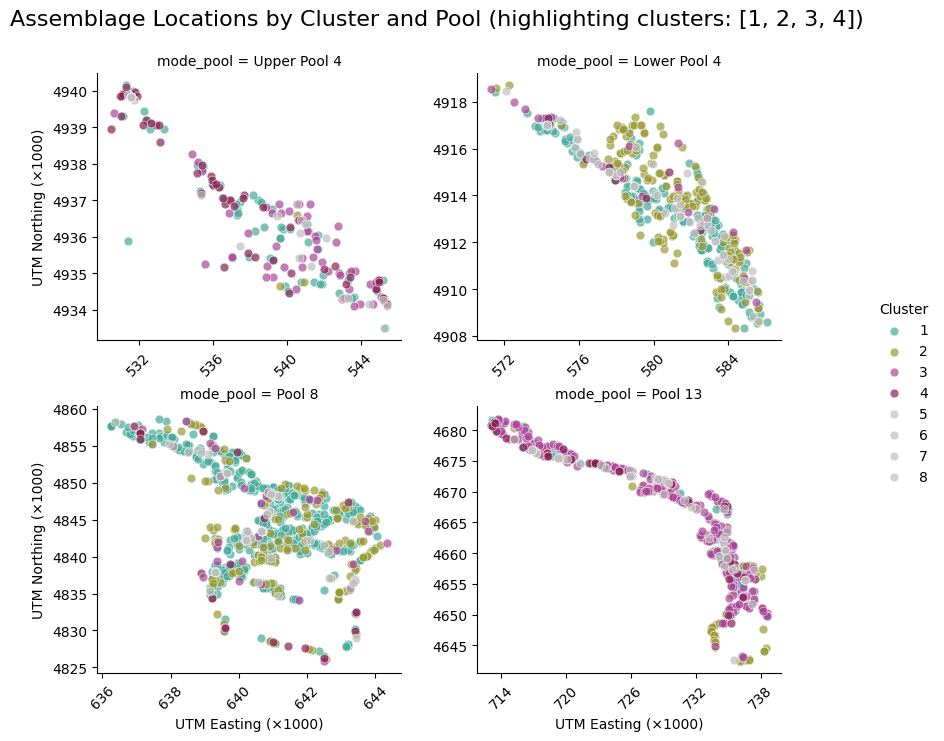

In [39]:
import tol_colors as tc

CB_PALETTE = tc.bright
# Fallback colors for clusters > 8
EXTRA_COLORS = ['#882255', '#44AA99', '#999933', '#AA4499']
GREY_COLOR = (0.75, 0.75, 0.75)  # light gray for non-highlighted clusters

# =============================================================================
# CONFIGURATION: Select clusters to highlight
# =============================================================================
highlight_clusters = [1, 2, 3, 4]  # <-- CHANGE THIS to select clusters (set to None or [] to show all)

# Minimum cluster size filter
min_cluster_size = 30

# Define pool order for facets (2 columns: row1 = Pool 4s, row2 = Pool 8 & 13)
pool_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]

# =============================================================================
# Data preparation
# =============================================================================
# Filter cluster size over threshold
cluster_counts = df_explore['cluster'].value_counts()
clusters_over_threshold = cluster_counts[cluster_counts >= min_cluster_size].index
df_plot = df_explore[df_explore['cluster'].isin(clusters_over_threshold)].copy()

# Filter to only include pools in our desired order
df_plot = df_plot[df_plot['mode_pool'].isin(pool_order)].copy()

# Set mode_pool as ordered categorical to control facet order
df_plot['mode_pool'] = pd.Categorical(
    df_plot['mode_pool'], 
    categories=pool_order, 
    ordered=True
)

cluster_sizes = df_plot['cluster'].value_counts()
unique_clusters = sorted(df_plot['cluster'].unique())

# =============================================================================
# Build color map: use consistent CB colors, grey out non-highlighted clusters
# =============================================================================
def get_cluster_color(cluster_num):
    """Get the consistent CB-friendly color for a cluster number."""
    if cluster_num in CB_PALETTE:
        return CB_PALETTE[cluster_num]
    else:
        idx = (cluster_num - len(CB_PALETTE) - 1) % len(EXTRA_COLORS)
        return EXTRA_COLORS[idx]

color_map = {}
for c in unique_clusters:
    if highlight_clusters:
        # If highlighting, only selected clusters get their color
        if c in highlight_clusters:
            color_map[c] = get_cluster_color(c)
        else:
            color_map[c] = GREY_COLOR
    else:
        # No highlighting: all clusters get their assigned color
        color_map[c] = get_cluster_color(c)

g = sns.FacetGrid(
    df_plot,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=2,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=40)

# Format axes in thousands
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1000:.0f}'))

g.set_axis_labels("UTM Easting (×1000)", "UTM Northing (×1000)")

# Add legend positioned closer to the plots
g.add_legend(title="Cluster", bbox_to_anchor=(1.0, 0.5), loc='center left')

# Update title
if highlight_clusters:
    title_suffix = f" (highlighting clusters: {highlight_clusters})"
else:
    title_suffix = ""
g.figure.suptitle(f"Assemblage Locations by Cluster and Pool{title_suffix}", fontsize=16)

# Adjust layout with more bottom space for rotated labels and proper right margin
g.figure.subplots_adjust(right=0.9, bottom=0.15, top=0.90, hspace=0.25, wspace=0.25)

plt.show()

## Clusters over time

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import f as f_dist
from plotnine import *

# Calculate proportion of samples in each cluster per year
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
total_per_year = cluster_time.groupby('year')['count'].transform('sum')
cluster_time['proportion'] = cluster_time['count'] / total_per_year
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Calculate proportion per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
total_per_year_pool = cluster_time_pool.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_time_pool['proportion'] = cluster_time_pool['count'] / total_per_year_pool
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
grp_size2 = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = cluster_time_pool[grp_size2 >= 2]

# ensure desired pool order and filter to clusters < 5
desired_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]


cluster_filter = [1, 2, 3, 4]
cluster_time_pool_lt5 = cluster_time_pool[cluster_time_pool['cluster'].astype(int).isin(cluster_filter)].copy()
filtered_smooth_lt5 = filtered_smooth[filtered_smooth['cluster'].astype(int).isin(cluster_filter)].copy()

cluster_time_pool_lt5['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
filtered_smooth_lt5['mode_pool'] = pd.Categorical(filtered_smooth_lt5['mode_pool'], categories=desired_order, ordered=True)


# =====================================================================
# SEGMENTED REGRESSION FOR ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

def piecewise_linear(x, x0, y0, m1, m2):
    """
    Continuous piecewise linear function with breakpoint at x0.
    Left (x <= x0): y = y0 + m1*(x - x0)
    Right (x > x0): y = y0 + m2*(x - x0)
    """
    return np.piecewise(
        x,
        [x <= x0, x > x0],
        [lambda z: y0 + m1 * (z - x0),
         lambda z: y0 + m2 * (z - x0)]
    )

def fit_segmented_regression(years, proportions, min_points=6):
    """
    Fit continuous segmented regression with one breakpoint using curve_fit.
    
    Returns:
    --------
    dict with fit results or None if insufficient data
    """
    years = np.asarray(years, dtype=float)
    proportions = np.asarray(proportions, dtype=float)
    
    if len(years) < min_points:
        return None
    
    # Initial guesses
    x0_guess = np.median(years)
    y0_guess = proportions[np.argmin(np.abs(years - x0_guess))]
    m1_guess = 0.0
    m2_guess = 0.0
    p0 = [x0_guess, y0_guess, m1_guess, m2_guess]
    
    # Bounds: keep breakpoint inside observed range
    bounds = (
        [years.min(), -np.inf, -np.inf, -np.inf],
        [years.max(),  np.inf,  np.inf,  np.inf]
    )
    
    try:
        # Fit piecewise model
        params, cov = optimize.curve_fit(
            piecewise_linear,
            years, proportions,
            p0=p0,
            bounds=bounds,
            maxfev=10000
        )
        
        x0_fit, y0_fit, m1_fit, m2_fit = params
        y_hat = piecewise_linear(years, *params)
        rss_piece = np.sum((proportions - y_hat)**2)
        
        # Simple linear model for comparison
        slope_simple, intercept_simple = np.polyfit(years, proportions, 1)
        y_hat_simple = slope_simple * years + intercept_simple
        rss_simple = np.sum((proportions - y_hat_simple)**2)
        
        # F-test
        n = len(years)
        k_piece = 4  # x0, y0, m1, m2
        k_simple = 2
        
        if n > k_piece and rss_piece > 0:
            f_stat = ((rss_simple - rss_piece) / (k_piece - k_simple)) / (rss_piece / (n - k_piece))
            p_value = 1 - f_dist.cdf(f_stat, k_piece - k_simple, n - k_piece)
        else:
            f_stat = np.nan
            p_value = np.nan
        
        return {
            'breakpoint': x0_fit,
            'y_at_break': y0_fit,
            'slope_before': m1_fit,
            'slope_after': m2_fit,
            'rss_piecewise': rss_piece,
            'rss_simple': rss_simple,
            'improvement_pct': 100 * (rss_simple - rss_piece) / rss_simple if rss_simple > 0 else 0,
            'f_stat': f_stat,
            'p_value': p_value,
            'significant': (p_value < 0.05) if not np.isnan(p_value) else False,
            'n_points': n,
            'params': params,
            'cov': cov
        }
    
    except Exception as e:
        print(f"  Warning: Fit failed - {str(e)}")
        return None

# =====================================================================
# FIT ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

results = []
fitted_data = []

for (pool, cluster), grp in cluster_time_pool_lt5.groupby(['mode_pool', 'cluster'], observed=False):
    # Sort and convert to numpy
    sub = grp[['year', 'proportion']].dropna().sort_values('year')
    years = sub['year'].to_numpy(dtype=float)
    props = sub['proportion'].to_numpy(dtype=float)
    
    res = fit_segmented_regression(years, props)
    
    if res:
        # Store results
        results.append({
            'mode_pool': pool,
            'cluster': cluster,
            'breakpoint_year': res['breakpoint'],
            'y_at_breakpoint': res['y_at_break'],
            'slope_before': res['slope_before'],
            'slope_after': res['slope_after'],
            'improvement_pct': res['improvement_pct'],
            'f_statistic': res['f_stat'],
            'p_value': res['p_value'],
            'significant': res['significant'],
            'n_points': res['n_points']
        })
        
        # Generate fitted values for plotting
        y_fitted = piecewise_linear(years, *res['params'])
        for yr, y_fit in zip(years, y_fitted):
            fitted_data.append({
                'mode_pool': pool,
                'cluster': cluster,
                'year': yr,
                'fitted': y_fit
            })

# Convert to DataFrames
segmented_results_df = pd.DataFrame(results).sort_values(['mode_pool', 'cluster'])
fitted_values_df = pd.DataFrame(fitted_data)

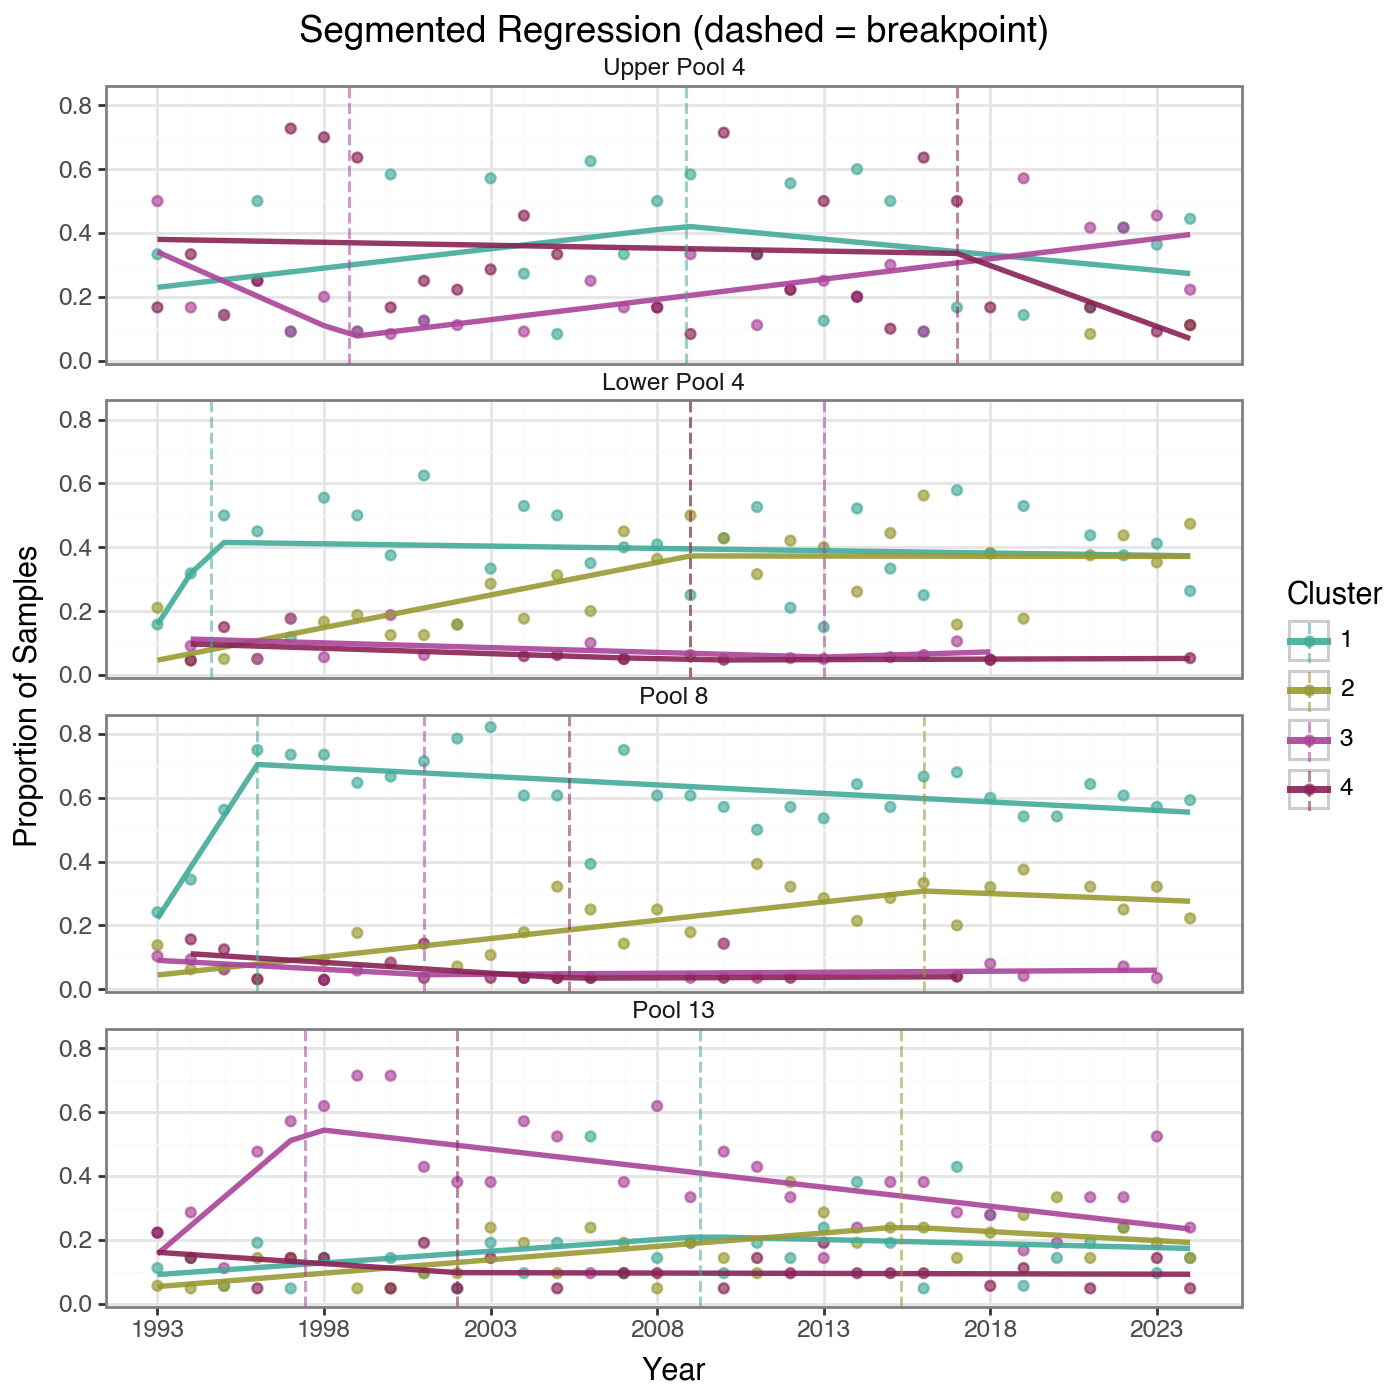

In [42]:
annotated_data = cluster_time_pool_lt5.merge(
     segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 'significant']],
     on=['mode_pool', 'cluster'],
     how='left'
)

annotated_data['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
fitted_values_df['mode_pool'] = pd.Categorical(fitted_values_df['mode_pool'], categories=desired_order, ordered=True)
# Filter out rows with missing breakpoint_year for the vline layer
breakpoint_data = annotated_data.dropna(subset=['breakpoint_year'])

# Build color map for the clusters in this plot (string keys for plotnine)
clusters_in_plot = sorted(cluster_time_pool_lt5['cluster'].unique(), key=int)
plot_color_map = {}
for cluster_str in cluster_time_pool_lt5['cluster'].unique():
    cluster_int = int(cluster_str)
    if cluster_int in color_map:
        plot_color_map[cluster_str] = color_map[cluster_int]
    else:
        plot_color_map[cluster_str] = '#999999'  # fallback gray

# Display plot
(
    ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
    geom_point(size=1.5, alpha=0.65) +
    geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
              size=1.1, alpha=0.9) +
    geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
               linetype='dashed', alpha=0.55, size=0.6) +
    facet_wrap('~mode_pool', ncol=1) +
    scale_color_manual(values=plot_color_map) +
    labs(x='Year', y='Proportion of Samples', color='Cluster',
         title='Segmented Regression (dashed = breakpoint)') +
    theme_bw() +
    theme(figure_size=(7, 7), strip_background=element_blank())
)
# Save the plot using ggsave
p = (
     ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
     geom_point(size=1.5, alpha=0.65) +
     geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
                 size=1.1, alpha=0.9) +
     geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
                  linetype='dashed', alpha=0.55, size=0.6) +
     facet_wrap('~mode_pool', ncol=1) +
     scale_x_continuous(minor_breaks=range(1993, 2024, 1), breaks=range(1993, 2024, 5)) +
     scale_color_manual(values=plot_color_map) +
     labs(x='Year', y='Proportion of Samples', color='Cluster',
           title='Segmented Regression (dashed = breakpoint)') +
     theme_bw() +
     theme(figure_size=(7, 7), strip_background=element_blank())
)

p.save('segmented_regression_clusters.jpg', dpi=300, verbose=False)
p.show()

In [ ]:
# Create formatted table with F-stat and p-value
stats_table = segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 
                                     'f_statistic', 'p_value']].copy()

stats_table['breakpoint_year'] = stats_table['breakpoint_year'].astype(int)
stats_table['f_statistic'] = stats_table['f_statistic'].round(2)
stats_table['p_value'] = stats_table['p_value'].round(4)

# Add significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

stats_table['sig'] = stats_table['p_value'].apply(get_significance_stars)

# Reorder rows to match desired pool order
stats_table['mode_pool'] = pd.Categorical(
    stats_table['mode_pool'], 
    categories=desired_order, 
    ordered=True
)
stats_table = stats_table.sort_values(['mode_pool', 'cluster'])

print("\n" + "=" * 60)
print("SEGMENTED REGRESSION STATISTICS")
print("=" * 60)
print(stats_table.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import f as f_dist
from plotnine import *

# Calculate proportion of samples in each cluster per year
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
total_per_year = cluster_time.groupby('year')['count'].transform('sum')
cluster_time['proportion'] = cluster_time['count'] / total_per_year
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Calculate proportion per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
total_per_year_pool = cluster_time_pool.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_time_pool['proportion'] = cluster_time_pool['count'] / total_per_year_pool
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
grp_size2 = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = cluster_time_pool[grp_size2 >= 2]

# ensure desired pool order and filter to clusters < 5
desired_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]


cluster_filter = [1, 2, 3, 4]
cluster_time_pool_lt5 = cluster_time_pool[cluster_time_pool['cluster'].astype(int).isin(cluster_filter)].copy()
filtered_smooth_lt5 = filtered_smooth[filtered_smooth['cluster'].astype(int).isin(cluster_filter)].copy()

cluster_time_pool_lt5['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
filtered_smooth_lt5['mode_pool'] = pd.Categorical(filtered_smooth_lt5['mode_pool'], categories=desired_order, ordered=True)


# =====================================================================
# SEGMENTED REGRESSION FOR ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

def piecewise_linear(x, x0, y0, m1, m2):
    """
    Continuous piecewise linear function with breakpoint at x0.
    Left (x <= x0): y = y0 + m1*(x - x0)
    Right (x > x0): y = y0 + m2*(x - x0)
    """
    return np.piecewise(
        x,
        [x <= x0, x > x0],
        [lambda z: y0 + m1 * (z - x0),
         lambda z: y0 + m2 * (z - x0)]
    )

def fit_segmented_regression(years, proportions, min_points=6):
    """
    Fit continuous segmented regression with one breakpoint using curve_fit.
    
    Returns:
    --------
    dict with fit results or None if insufficient data
    """
    years = np.asarray(years, dtype=float)
    proportions = np.asarray(proportions, dtype=float)
    
    if len(years) < min_points:
        return None
    
    # Initial guesses
    x0_guess = np.median(years)
    y0_guess = proportions[np.argmin(np.abs(years - x0_guess))]
    m1_guess = 0.0
    m2_guess = 0.0
    p0 = [x0_guess, y0_guess, m1_guess, m2_guess]
    
    # Bounds: keep breakpoint inside observed range
    bounds = (
        [years.min(), -np.inf, -np.inf, -np.inf],
        [years.max(),  np.inf,  np.inf,  np.inf]
    )
    
    try:
        # Fit piecewise model
        params, cov = optimize.curve_fit(
            piecewise_linear,
            years, proportions,
            p0=p0,
            bounds=bounds,
            maxfev=10000
        )
        
        x0_fit, y0_fit, m1_fit, m2_fit = params
        y_hat = piecewise_linear(years, *params)
        rss_piece = np.sum((proportions - y_hat)**2)
        
        # Simple linear model for comparison
        slope_simple, intercept_simple = np.polyfit(years, proportions, 1)
        y_hat_simple = slope_simple * years + intercept_simple
        rss_simple = np.sum((proportions - y_hat_simple)**2)
        
        # F-test
        n = len(years)
        k_piece = 4  # x0, y0, m1, m2
        k_simple = 2
        
        if n > k_piece and rss_piece > 0:
            f_stat = ((rss_simple - rss_piece) / (k_piece - k_simple)) / (rss_piece / (n - k_piece))
            p_value = 1 - f_dist.cdf(f_stat, k_piece - k_simple, n - k_piece)
        else:
            f_stat = np.nan
            p_value = np.nan
        
        return {
            'breakpoint': x0_fit,
            'y_at_break': y0_fit,
            'slope_before': m1_fit,
            'slope_after': m2_fit,
            'rss_piecewise': rss_piece,
            'rss_simple': rss_simple,
            'improvement_pct': 100 * (rss_simple - rss_piece) / rss_simple if rss_simple > 0 else 0,
            'f_stat': f_stat,
            'p_value': p_value,
            'significant': (p_value < 0.05) if not np.isnan(p_value) else False,
            'n_points': n,
            'params': params,
            'cov': cov
        }
    
    except Exception as e:
        print(f"  Warning: Fit failed - {str(e)}")
        return None

# =====================================================================
# FIT ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

results = []
fitted_data = []

for (pool, cluster), grp in cluster_time_pool_lt5.groupby(['mode_pool', 'cluster'], observed=False):
    # Sort and convert to numpy
    sub = grp[['year', 'proportion']].dropna().sort_values('year')
    years = sub['year'].to_numpy(dtype=float)
    props = sub['proportion'].to_numpy(dtype=float)
    
    res = fit_segmented_regression(years, props)
    
    if res:
        # Store results
        results.append({
            'mode_pool': pool,
            'cluster': cluster,
            'breakpoint_year': res['breakpoint'],
            'y_at_breakpoint': res['y_at_break'],
            'slope_before': res['slope_before'],
            'slope_after': res['slope_after'],
            'improvement_pct': res['improvement_pct'],
            'f_statistic': res['f_stat'],
            'p_value': res['p_value'],
            'significant': res['significant'],
            'n_points': res['n_points']
        })
        
        # Generate fitted values for plotting
        y_fitted = piecewise_linear(years, *res['params'])
        for yr, y_fit in zip(years, y_fitted):
            fitted_data.append({
                'mode_pool': pool,
                'cluster': cluster,
                'year': yr,
                'fitted': y_fit
            })

# Convert to DataFrames
segmented_results_df = pd.DataFrame(results).sort_values(['mode_pool', 'cluster'])
fitted_values_df = pd.DataFrame(fitted_data)

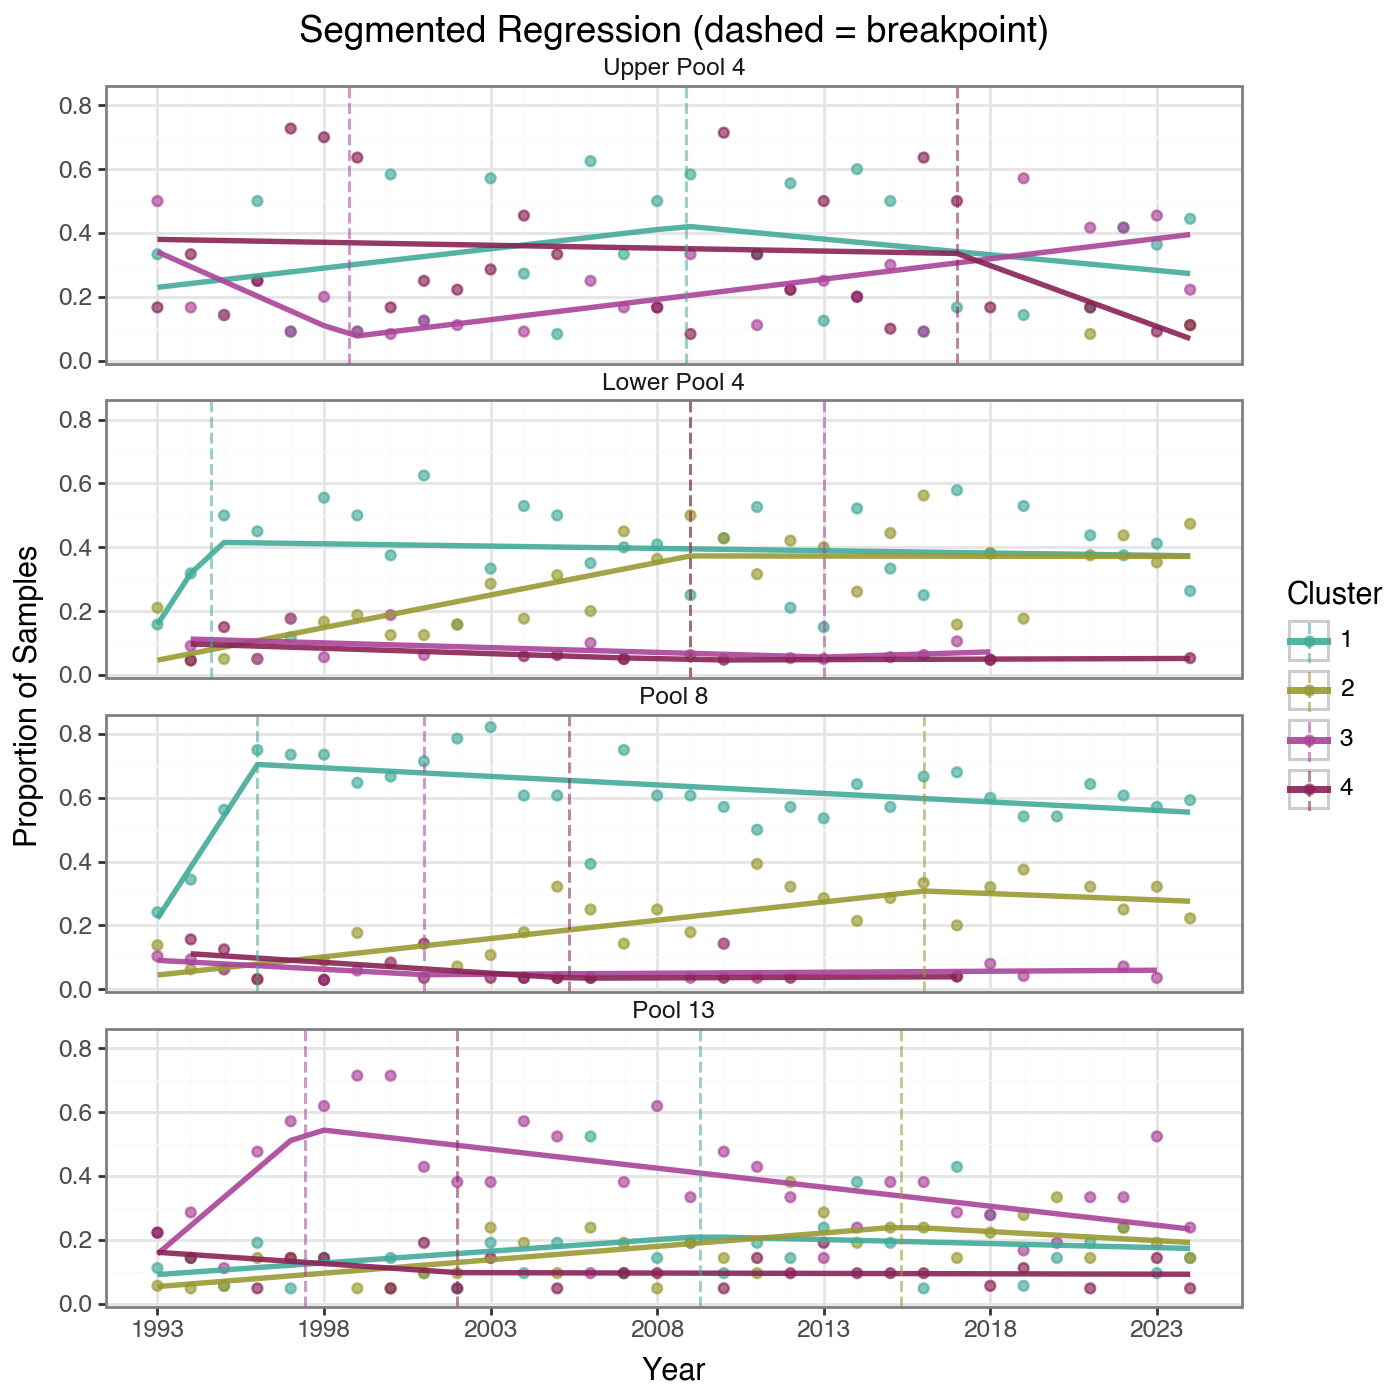

In [11]:
annotated_data = cluster_time_pool_lt5.merge(
     segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 'significant']],
     on=['mode_pool', 'cluster'],
     how='left'
)

annotated_data['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
fitted_values_df['mode_pool'] = pd.Categorical(fitted_values_df['mode_pool'], categories=desired_order, ordered=True)
# Filter out rows with missing breakpoint_year for the vline layer
breakpoint_data = annotated_data.dropna(subset=['breakpoint_year'])

# Build color map for the clusters in this plot (string keys for plotnine)
clusters_in_plot = sorted(cluster_time_pool_lt5['cluster'].unique(), key=int)
plot_color_map = {}
for cluster_str in cluster_time_pool_lt5['cluster'].unique():
    cluster_int = int(cluster_str)
    if cluster_int in color_map:
        plot_color_map[cluster_str] = color_map[cluster_int]
    else:
        plot_color_map[cluster_str] = '#999999'  # fallback gray

# Display plot
(
    ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
    geom_point(size=1.5, alpha=0.65) +
    geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
              size=1.1, alpha=0.9) +
    geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
               linetype='dashed', alpha=0.55, size=0.6) +
    facet_wrap('~mode_pool', ncol=1) +
    scale_color_manual(values=plot_color_map) +
    labs(x='Year', y='Proportion of Samples', color='Cluster',
         title='Segmented Regression (dashed = breakpoint)') +
    theme_bw() +
    theme(figure_size=(7, 7), strip_background=element_blank())
)
# Save the plot using ggsave
p = (
     ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
     geom_point(size=1.5, alpha=0.65) +
     geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
                 size=1.1, alpha=0.9) +
     geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
                  linetype='dashed', alpha=0.55, size=0.6) +
     facet_wrap('~mode_pool', ncol=1) +
     scale_x_continuous(minor_breaks=range(1993, 2024, 1), breaks=range(1993, 2024, 5)) +
     scale_color_manual(values=plot_color_map) +
     labs(x='Year', y='Proportion of Samples', color='Cluster',
           title='Segmented Regression (dashed = breakpoint)') +
     theme_bw() +
     theme(figure_size=(7, 7), strip_background=element_blank())
)

p.save('segmented_regression_clusters.jpg', dpi=300, verbose=False)
p.show()

In [12]:
# Create formatted table with F-stat and p-value
stats_table = segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 
                                     'f_statistic', 'p_value']].copy()

stats_table['breakpoint_year'] = stats_table['breakpoint_year'].astype(int)
stats_table['f_statistic'] = stats_table['f_statistic'].round(2)
stats_table['p_value'] = stats_table['p_value'].round(4)

# Add significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

stats_table['sig'] = stats_table['p_value'].apply(get_significance_stars)

# Reorder rows to match desired pool order
stats_table['mode_pool'] = pd.Categorical(
    stats_table['mode_pool'], 
    categories=desired_order, 
    ordered=True
)
stats_table = stats_table.sort_values(['mode_pool', 'cluster'])

print("\n" + "=" * 60)
print("SEGMENTED REGRESSION STATISTICS")
print("=" * 60)
print(stats_table.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")


SEGMENTED REGRESSION STATISTICS
   mode_pool cluster  breakpoint_year  f_statistic  p_value sig
Upper Pool 4       1             2008         0.85   0.4395    
Upper Pool 4       3             1998         5.89   0.0090  **
Upper Pool 4       4             2016         0.85   0.4422    
Lower Pool 4       1             1994         1.64   0.2136    
Lower Pool 4       2             2009         3.55   0.0427   *
Lower Pool 4       3             2013         0.18   0.8366    
Lower Pool 4       4             2008         0.28   0.7666    
      Pool 8       1             1995        20.81   0.0000 ***
      Pool 8       2             2015         1.91   0.1677    
      Pool 8       3             2001         1.16   0.3404    
      Pool 8       4             2005         0.58   0.5826    
     Pool 13       1             2009         0.66   0.5240    
     Pool 13       2             2015         1.79   0.1855    
     Pool 13       3             1997         6.26   0.0057  **
     Po

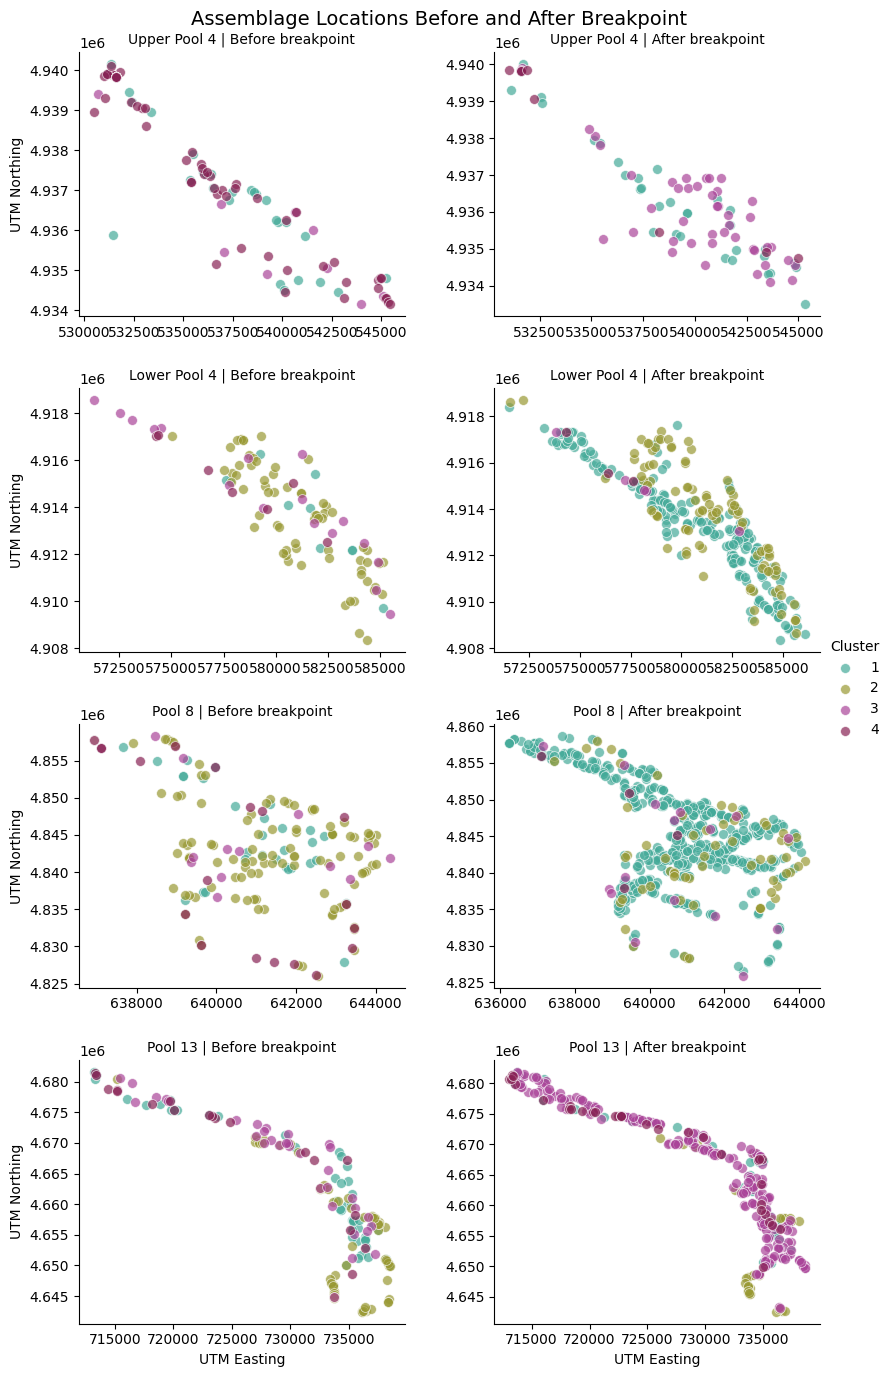

In [13]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())

# Ensure cluster dtype matches between df_explore and segmented_results_df to avoid merge errors
if 'cluster' in segmented_results_df.columns:
    target_dtype = df_explore['cluster'].dtype
    if segmented_results_df['cluster'].dtype != target_dtype:
        # If df_explore cluster is integer-like, cast segmented_results_df cluster to int
        if np.issubdtype(target_dtype, np.integer):
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(int)
        else:
            # otherwise cast to the same dtype as df_explore
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(target_dtype)

# Merge breakpoint data with df_explore
df_with_breakpoints = df_explore.merge(
    segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year']],
    on=['mode_pool', 'cluster'],
    how='left'
)

# Create before/after period column
def assign_period(row):
    if pd.isna(row['breakpoint_year']):
        return 'No breakpoint'
    elif row['year'] <= row['breakpoint_year']:
        return 'Before breakpoint'
    else:
        return 'After breakpoint'

df_with_breakpoints['period'] = df_with_breakpoints.apply(assign_period, axis=1)

# Filter to desired pools and clusters
df_filtered = df_with_breakpoints[
    (df_with_breakpoints['mode_pool'].isin(desired_order)) &
    (df_with_breakpoints['cluster'].isin(cluster_filter)) &
    (df_with_breakpoints['period'] != 'No breakpoint')
].copy()

# Set categorical order for mode_pool
df_filtered['mode_pool'] = pd.Categorical(
    df_filtered['mode_pool'], 
    categories=desired_order, 
    ordered=True
)

# Create FacetGrid with row=mode_pool, col=period
g = sns.FacetGrid(
    df_filtered,
    row="mode_pool",
    col="period",
    hue="cluster",
    palette=color_map,
    height=3.5,
    aspect=1.2,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=50)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.figure.subplots_adjust(top=0.95)
g.figure.suptitle("Assemblage Locations Before and After Breakpoint", fontsize=14)
plt.show()

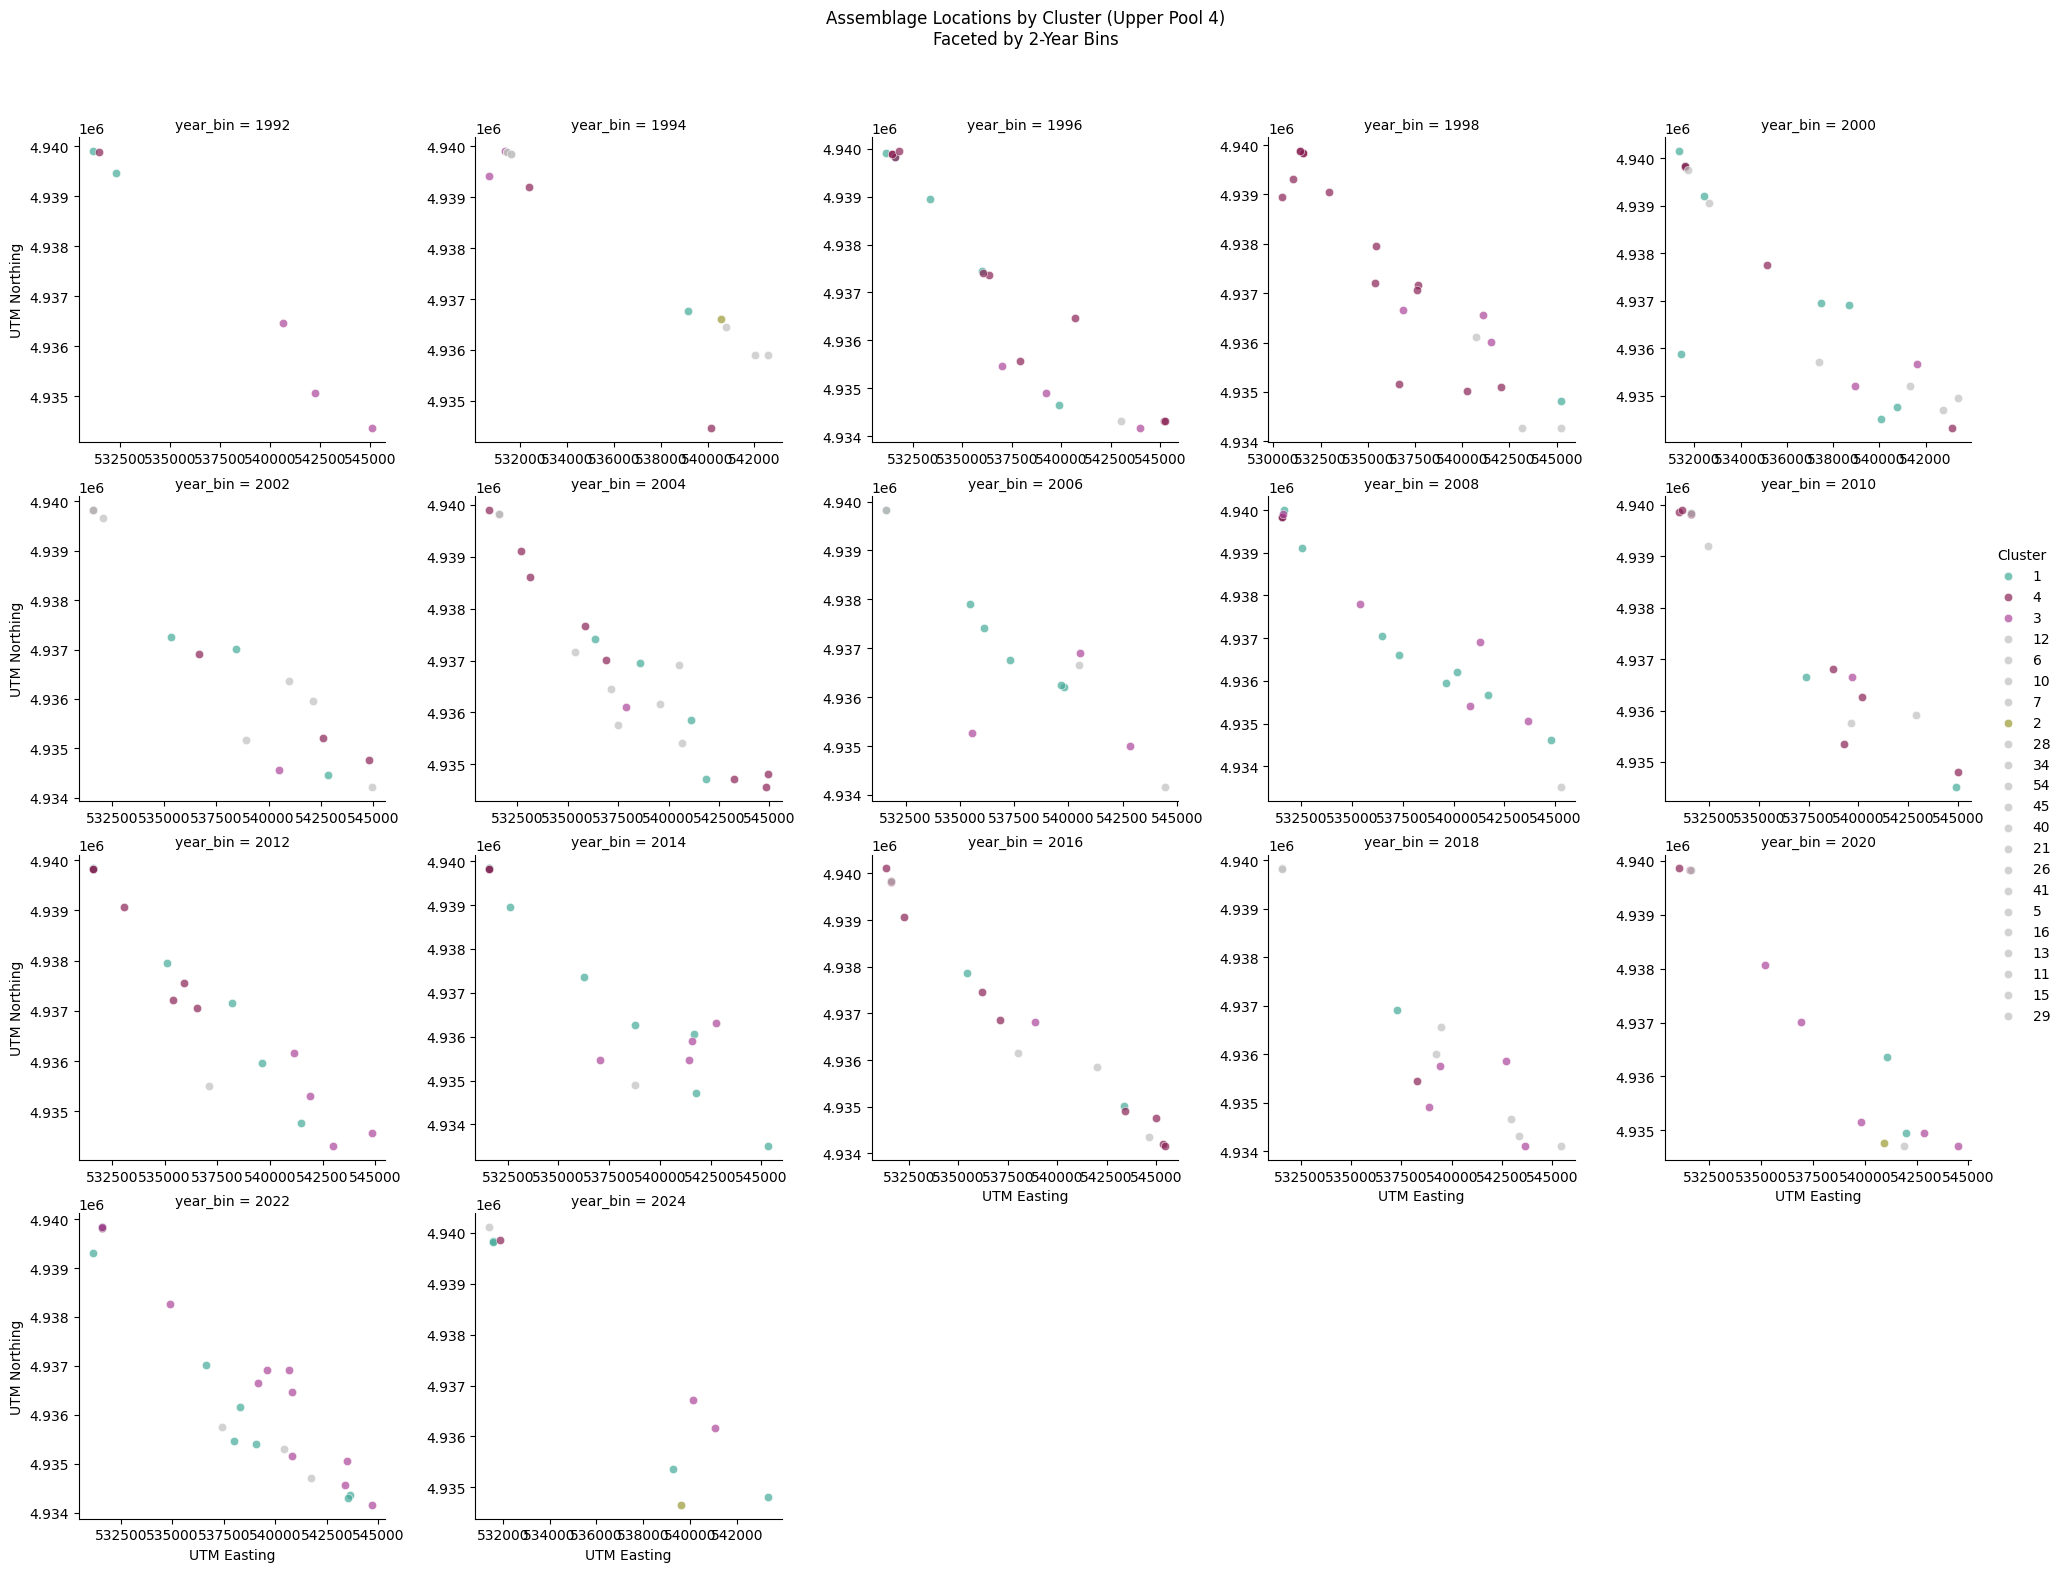

In [18]:
# Use the same color_map as the global plot

pool_filter = "Upper Pool 4"  # Change this to select different pools

cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = cluster_sizes.idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
#palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray
available_pools = df_explore['mode_pool'].unique()
if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()
    
    YEAR_BIN = 2
    # Create a new column for year bins
    df_pool['year_bin'] = ((df_pool['year']) // YEAR_BIN) * YEAR_BIN

    # Ensure cluster column is string type for consistency (optional, for legend order)
    df_pool['cluster'] = df_pool['cluster'].astype(str)

    # Create a string-keyed palette from the global color_map, ensuring all clusters in df_pool are included
    str_color_map = {}
    for c in df_pool['cluster'].unique():
        c_int = int(c)
        if c_int in color_map:
            str_color_map[c] = color_map[c_int]
        else:
            str_color_map[c] = GREY_COLOR  # Use grey for clusters not in color_map

    # Create the FacetGrid using the string-keyed color map
    g = sns.FacetGrid(
        df_pool,
        col="year_bin",
        col_wrap=5,
        height=4,
        sharex=False,
        sharey=False,
        hue="cluster",
        palette=str_color_map  # Use string-keyed color map for consistency
    )
    g.map_dataframe(
        sns.scatterplot,
        x="utm_e",
        y="utm_n",
        alpha=0.7
    )
    g.add_legend(title="Cluster")
    g.set_axis_labels("UTM Easting", "UTM Northing")
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(f"Assemblage Locations by Cluster ({pool_filter})\nFaceted by {YEAR_BIN}-Year Bins")
    plt.show()


DFA for proportion of samples in each cluster over time, faceted by pool.

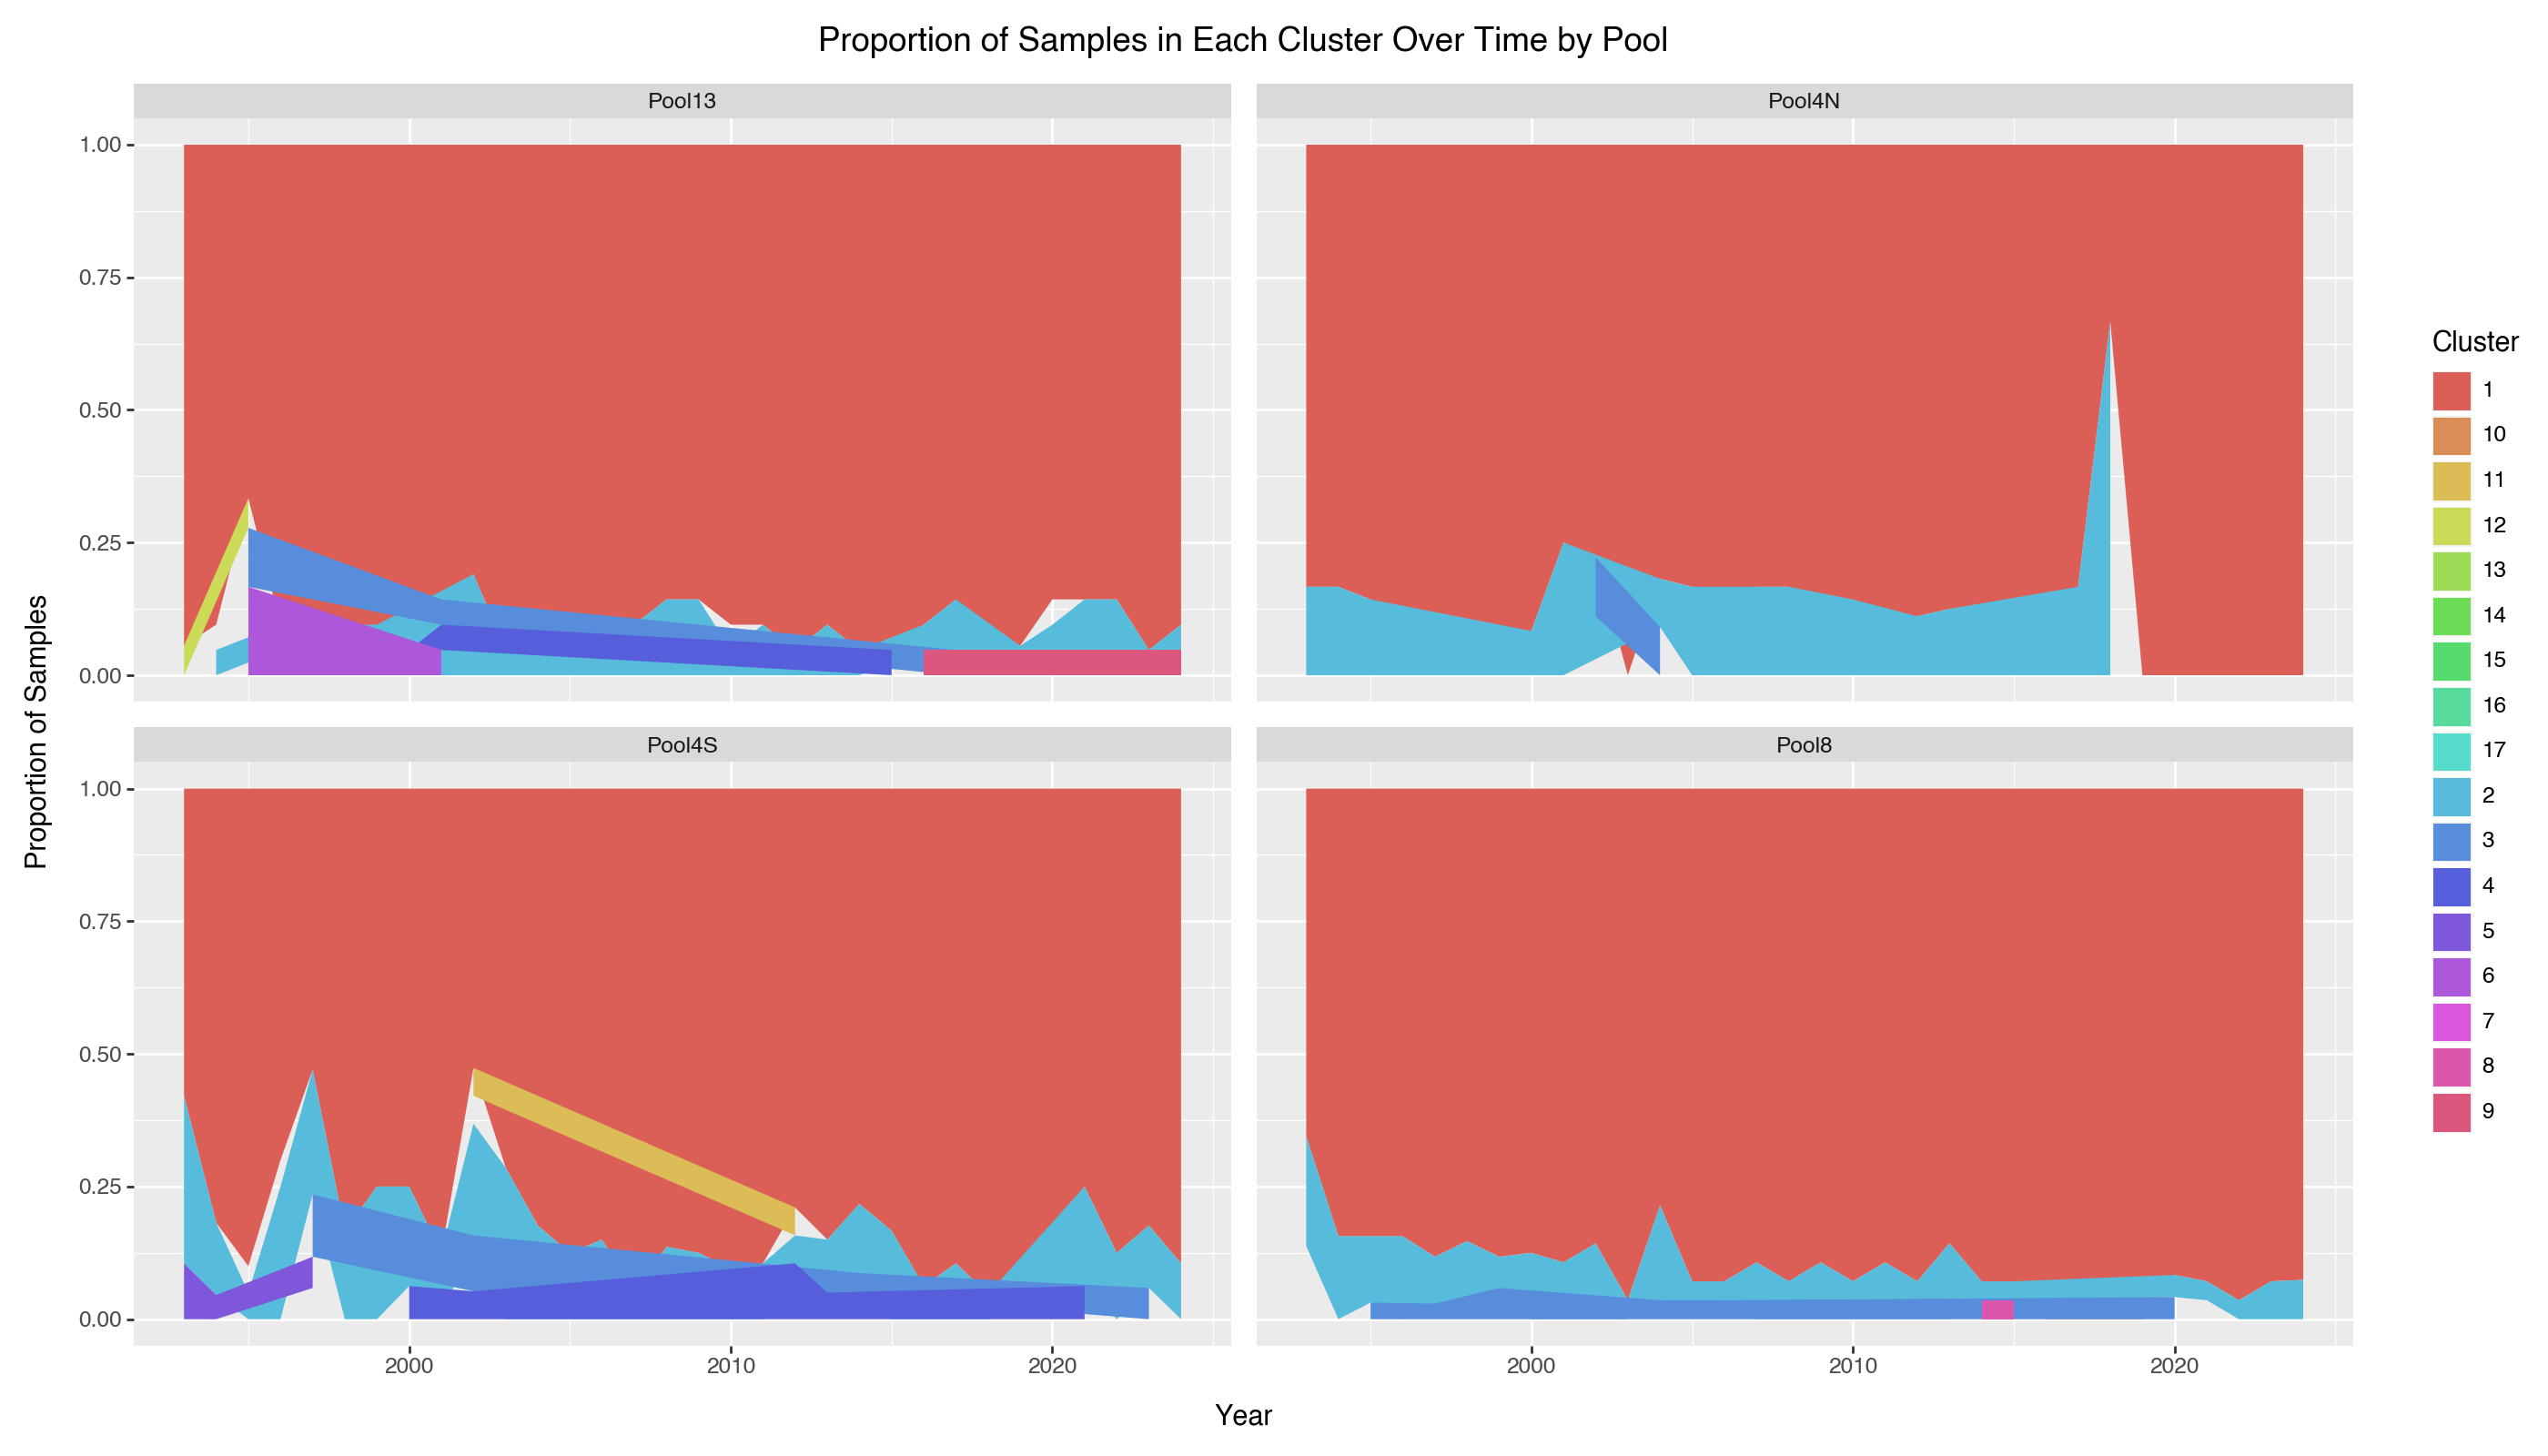

In [ ]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_explore.groupby(['year', 'mode_pool', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals

# Convert cluster to string for plotting
cluster_proportions['cluster'] = cluster_proportions['cluster'].astype(str)

# Create stacked area plot showing proportions over time, faceted by pool
(ggplot(cluster_proportions, aes(x='year', y='proportion', fill='cluster')) +
 geom_area(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
    title='Proportion of Samples in Each Cluster Over Time by Pool') +
 theme(figure_size=(14, 8))
)

/var/folders/5f/8wj2hdcx4p14q972y40gpgpc0000gn/T/ipykernel_6921/1790906780.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


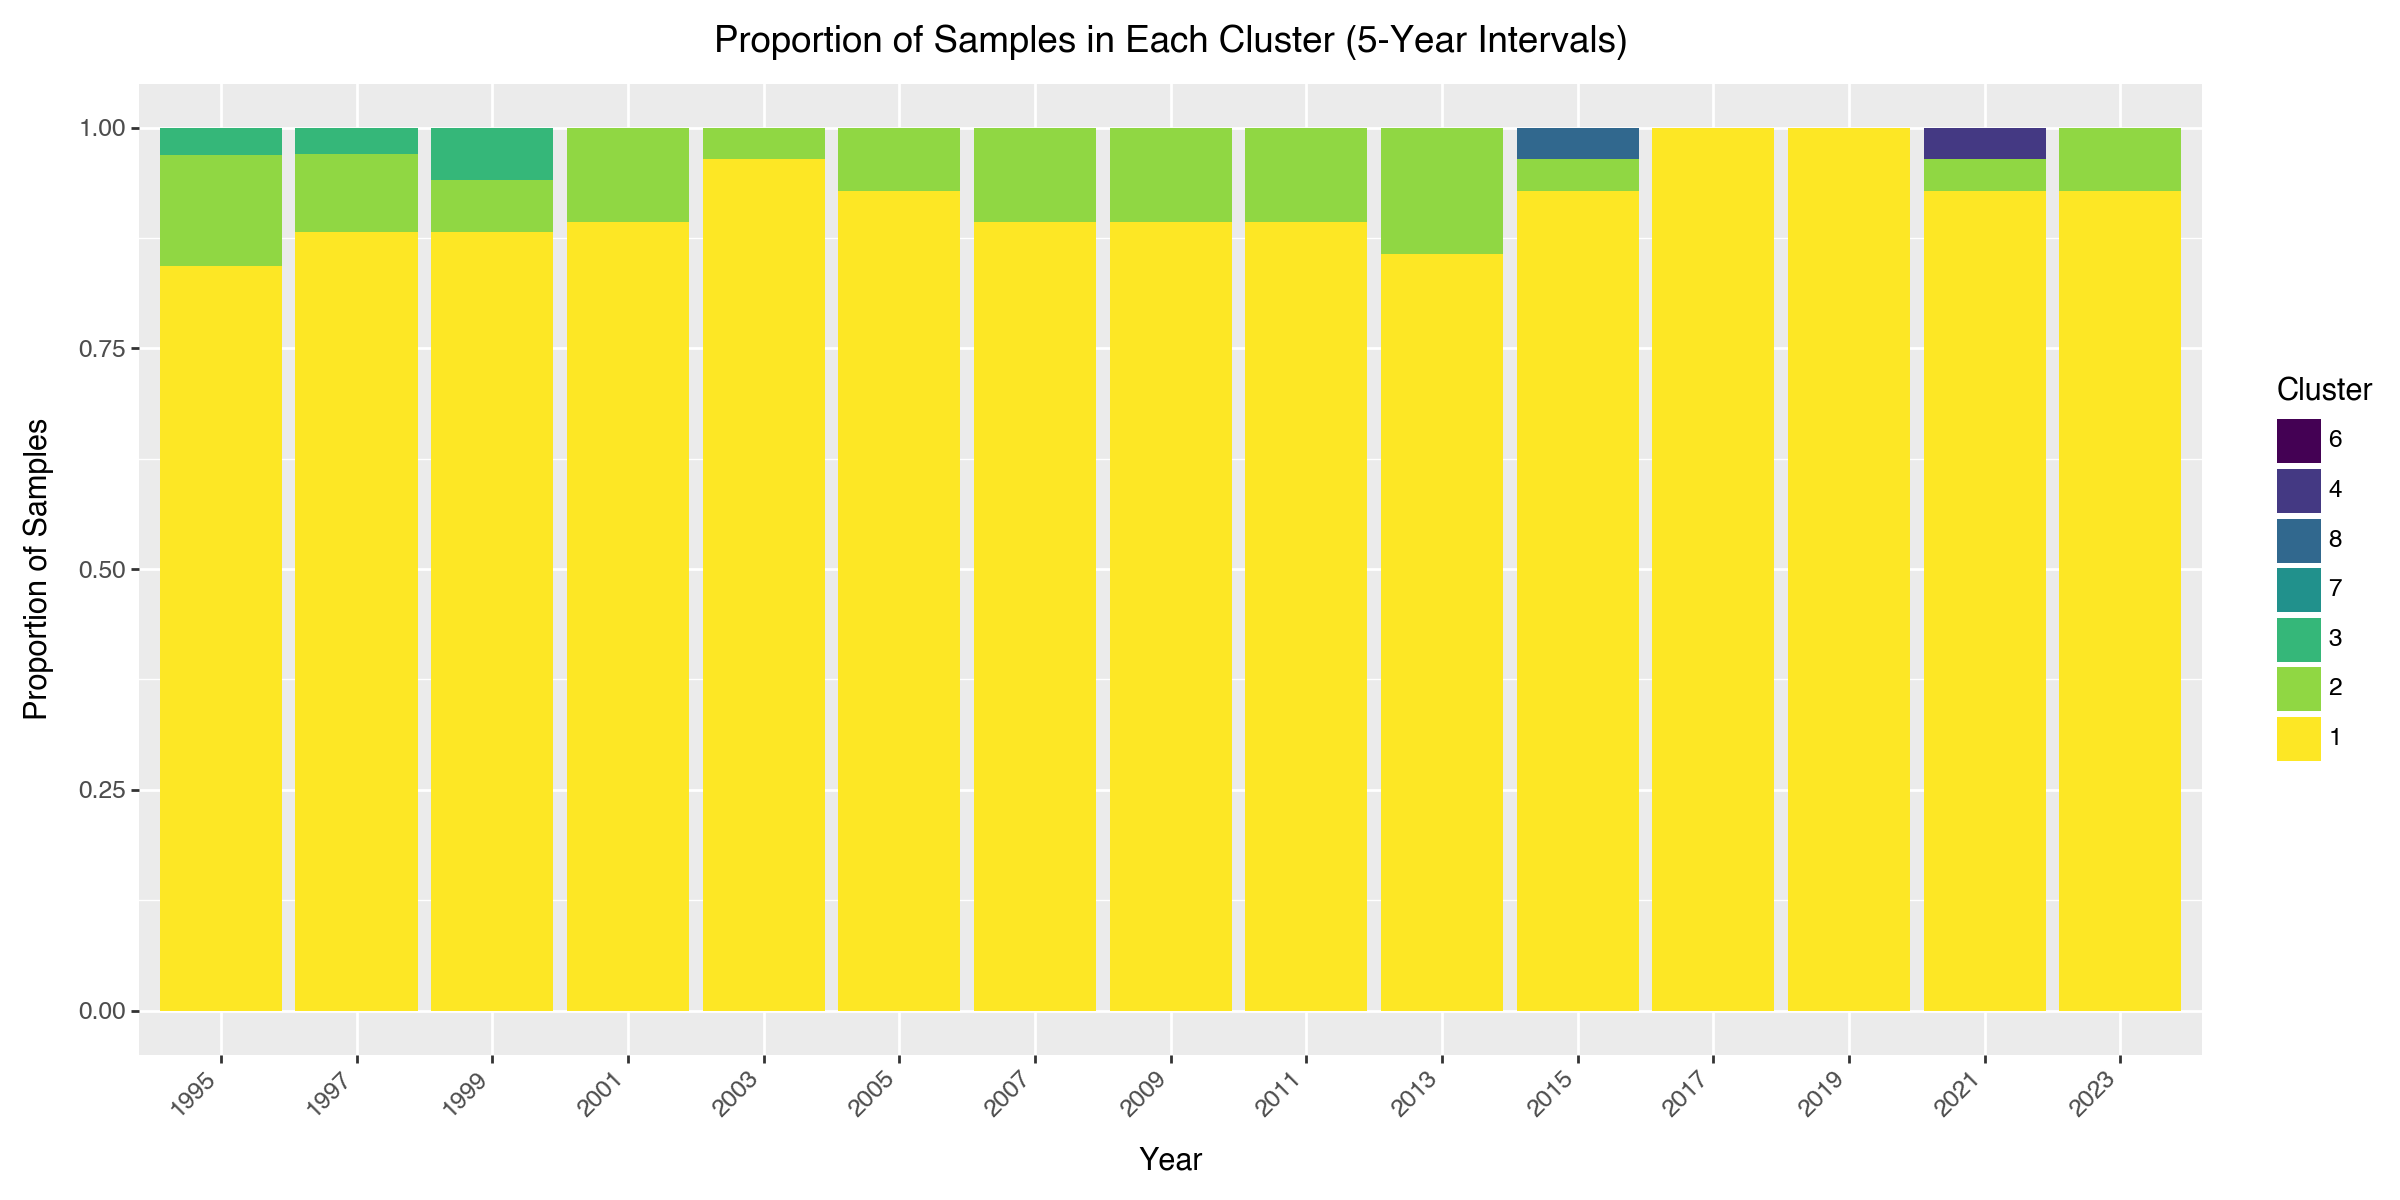

In [ ]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_pool.groupby(['year', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals


# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1995, df_pool['year'].max() + 1, 2))

# Filter cluster_proportions for these years
cluster_proportions_filtered = cluster_proportions[cluster_proportions['year'].isin(years_to_plot)]

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = cluster_proportions.groupby('cluster')['proportion'].sum().sort_values(ascending=True).index.astype(str)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)

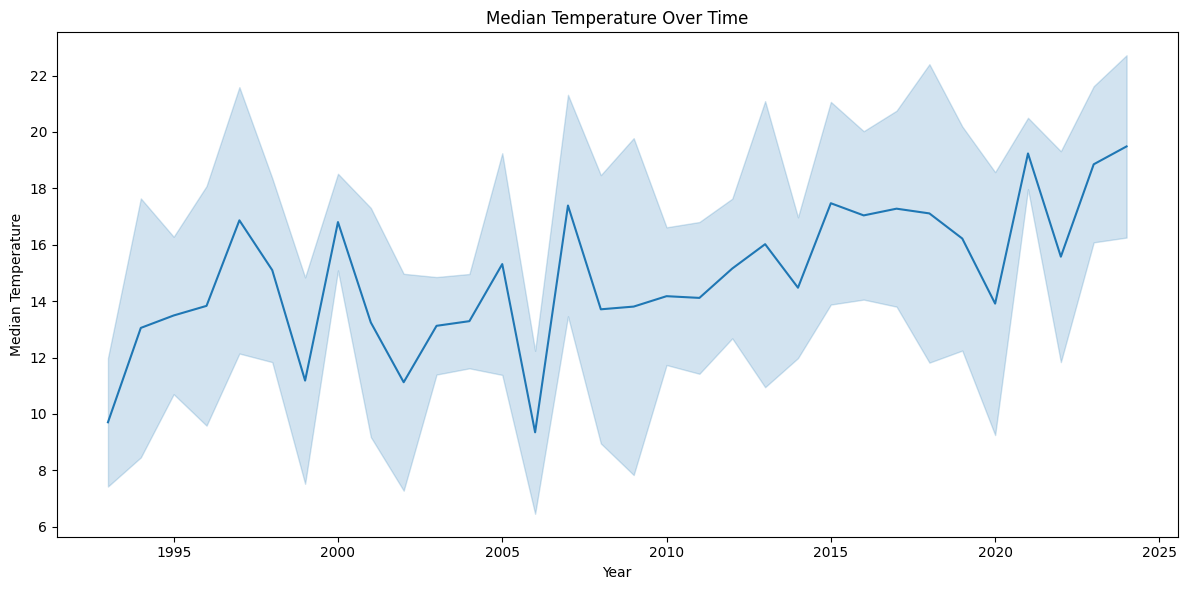

In [ ]:
# Plot median temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pool, x='year', y='median_temp', estimator='mean', errorbar='sd')
plt.xlabel('Year')
plt.ylabel('Median Temperature')
plt.title('Median Temperature Over Time')
plt.tight_layout()
plt.show()

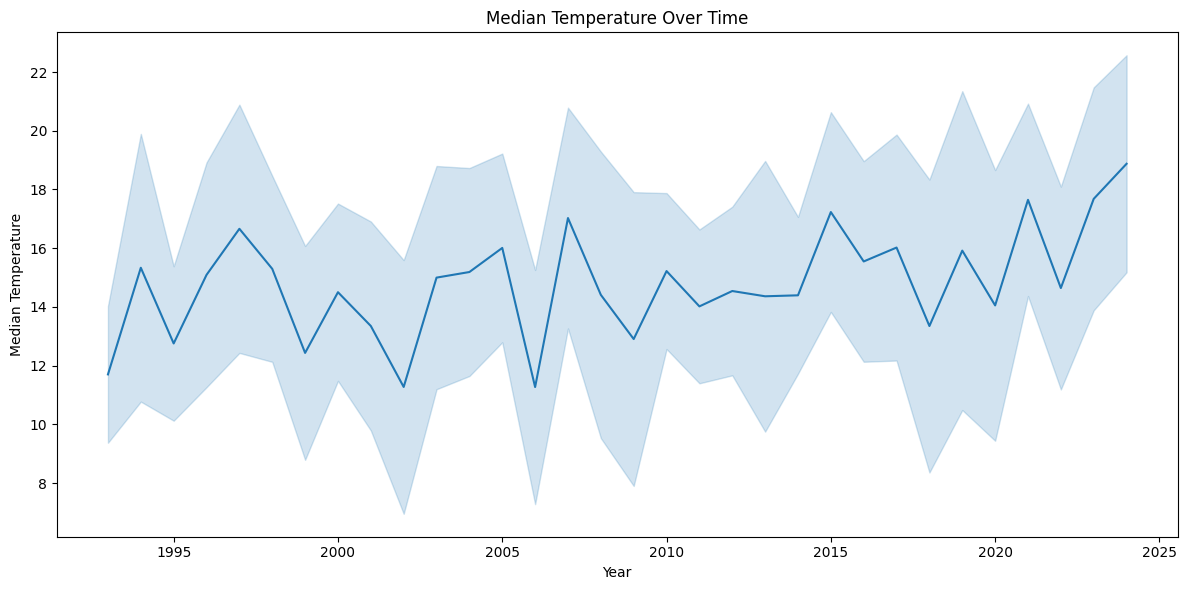

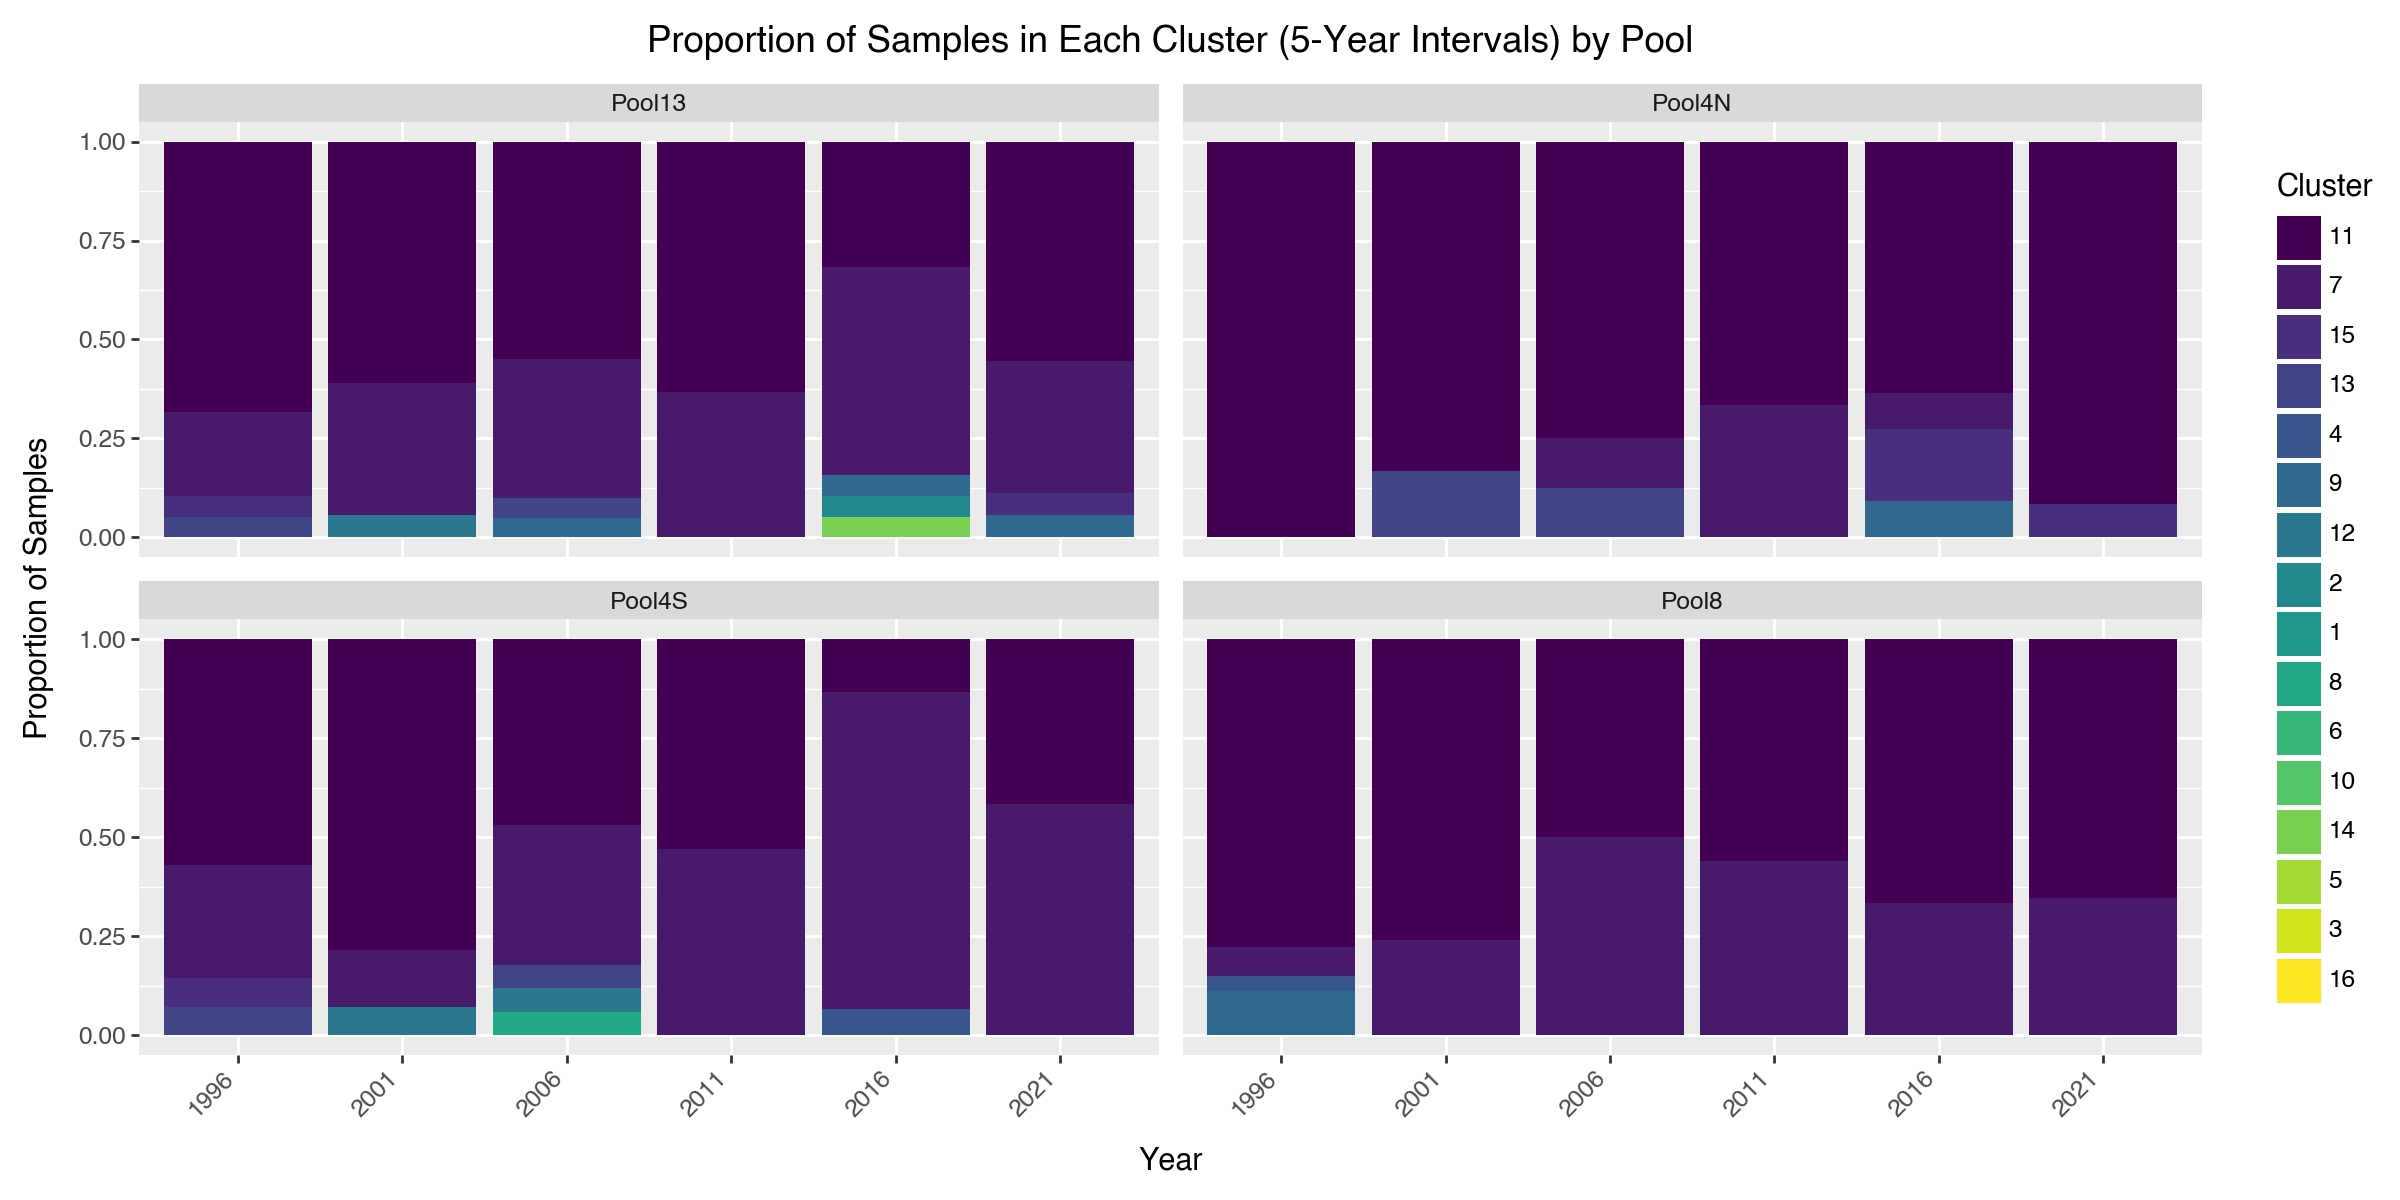

In [ ]:
# ...existing code...
# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1996, df_explo['year'].max() + 1, 5))

# Filter cluster_proportions for these years (copy to avoid SettingWithCopy warnings)
cluster_proportions_filtered = (
    cluster_proportions.loc[cluster_proportions['year'].isin(years_to_plot)].copy()
)

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=False)
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Make year an ordered categorical so bars are chronological
cluster_proportions_filtered['year'] = pd.Categorical(
    cluster_proportions_filtered['year'],
    categories=years_to_plot,
    ordered=True
)

# Create stacked bar plot faceted by pool
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='year', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals) by Pool') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 65 rows containing missing values.


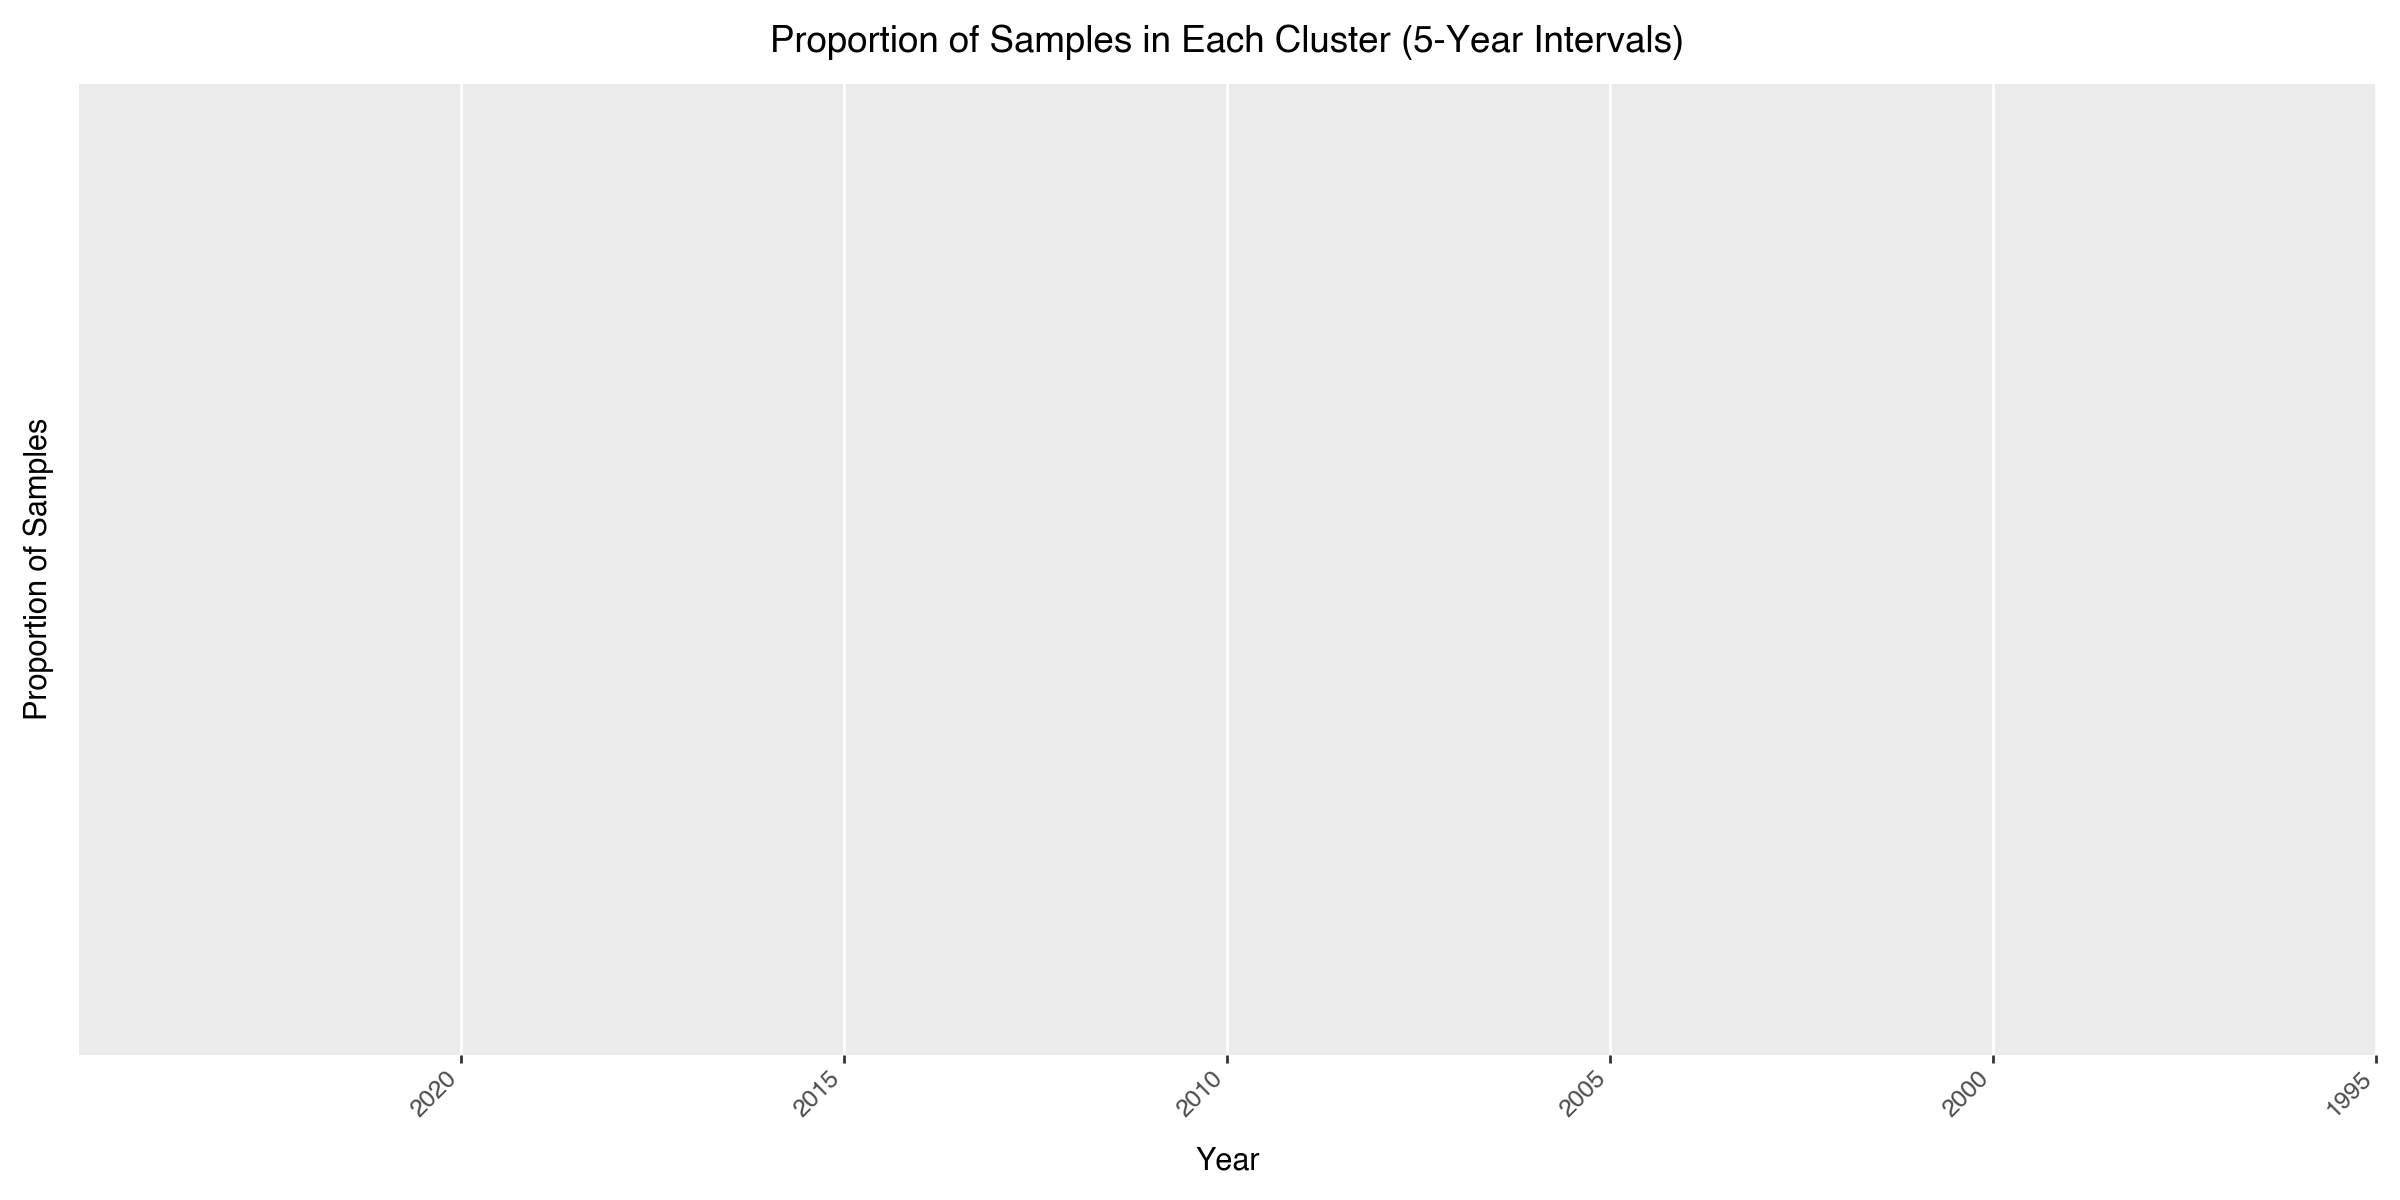

In [ ]:
# ...existing code...
# Sort clusters by overall proportion (reverse order)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=True)  # was descending
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot with reversed x (years) order
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 scale_x_discrete(limits=[str(y) for y in years_to_plot[::-1]]) +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...